# Forecasting population / rent growth

We are interested in forecasting population and rent growth. To validate the potential for training forecasting models on this task, and considering the setting of limited data that we fall under, we explore 3 regimes, and their impact on modeling performance:

- Increasing data quantity
- Increasing data expressiveness
- Increasing model complexity

### Exploration of candidate data

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [32]:
homes = pd.read_csv("regression_data/zillow_homeval_city.csv")
rents = pd.read_csv("regression_data/zillow_rent_city.csv")
pop = pd.read_csv("regression_data/city_population.csv")
pop.columns = pop.columns.str.strip()
pop["City"] = pop["City"].str.strip()
pop["State"] = pop["State"].str.strip()

print(f"{len(homes)} rows in homes dataset, {len(rents)} rows in rents dataset, {len(pop)} rows in population dataset")

tmp = pd.merge(homes, rents, on=["City", "State"], suffixes=("_home", "_rent"))

print(f"{len(tmp)} rows after merging homes and rents datasets")

merged = pd.merge(tmp, pop, on=["City", "State"], suffixes=("", "_pop"))
# Rename columns in merged to add _pop suffix to population-specific columns
pop_year_cols = [str(year) for year in range(2000, 2025)]
pop_yoy_cols = [f"{year}_yoy" for year in range(2000, 2025)]
cols_to_rename = {col: f"{col}_pop" for col in pop_year_cols + pop_yoy_cols if col in merged.columns}
merged = merged.rename(columns=cols_to_rename)

print(f"{len(merged)} rows after merging with population dataset")

print(f"{round((1 - len(tmp)/len(homes))*100, 2)}% data loss after merging the home/rent dataset with population")



21461 rows in homes dataset, 3990 rows in rents dataset, 258 rows in population dataset
3908 rows after merging homes and rents datasets
258 rows after merging with population dataset
81.79% data loss after merging the home/rent dataset with population


#### Analysis:

We lose 81.79% of the data when merging the home/rent datasets with the population level datasets. This indicates that, in the current analysis, the data-size bottleneck is the city-level population dataset. 

In [33]:
merged.head()

,City,State,2000_pop,2001_pop,2002_pop,2003_pop,2004_pop,2005_pop,2006_pop,2007_pop,2008_pop,2009_pop,2010_pop,2011_pop,2012_pop,2013_pop,2014_pop,2015_home,2016_home,2017_home,2018_home,2019_home,2020_home,2021_home,2022_home,2023_home,2024_home,2025_home,2001_yoy_pop,2002_yoy_pop,2003_yoy_pop,2004_yoy_pop,2005_yoy_pop,2006_yoy_pop,2007_yoy_pop,2008_yoy_pop,2009_yoy_pop,2010_yoy_pop,2011_yoy_pop,2012_yoy_pop,2013_yoy_pop,2014_yoy_pop,2015_yoy_pop,2016_yoy_home,2017_yoy_home,2018_yoy_home,2019_yoy_home,2020_yoy_home,2021_yoy_home,2022_yoy_home,2023_yoy_home,2024_yoy_home,2025_yoy_home,2015_rent,2016_rent,2017_rent,2018_rent,2019_rent,2020_rent,2021_rent,2022_rent,2023_rent,2024_rent,2025_rent,2016_yoy_rent,2017_yoy_rent,2018_yoy_rent,2019_yoy_rent,2020_yoy_rent,2021_yoy_rent,2022_yoy_rent,2023_yoy_rent,2024_yoy_rent,2025_yoy_rent,2010_pop,2011_pop,2012_pop,2013_pop,2014_pop,2015_pop,2016_pop,2017_pop,2018_pop,2019_pop,2020_pop,2021_pop,2022_pop,2023_pop,2024_pop,2011_yoy_pop,2012_yoy_pop,2013_yoy_pop,2014_yoy_pop,2015_yoy_pop,2016_yoy_pop,2017_yoy_pop,2018_yoy_pop,2019_yoy_pop,2020_yoy_pop,2021_yoy_pop,2022_yoy_pop,2023_yoy_pop,2024_yoy_pop
0,New York,NY,270040.975727,302863.744173,325463.453783,367727.101711,419779.979752,494491.148417,522289.463937,524852.746612,492729.765365,452207.471551,454977.598735,450310.840105,464738.983631,495237.154010,533075.577904,574064.144522,613806.599136,663572.786446,709255.914498,725366.964758,733710.540541,771157.731311,787829.628186,749848.766658,781606.166261,799870.657600,0.121547,0.074620,0.129857,0.141553,0.177977,0.056216,0.004908,-0.061204,-0.082240,0.006126,-0.010257,0.032040,0.065624,0.076405,0.076891,0.069230,0.081078,0.068844,0.022715,0.011503,0.051038,0.021619,-0.048209,0.042352,0.023368,2705.644097,2742.614352,2752.853425,2830.319256,2935.623325,2570.627094,3092.027721,3379.858466,3485.485386,3625.197333,3815.274845,0.013664,0.003733,0.028140,0.037206,-0.124333,0.202830,0.093088,0.031252,0.040084,0.052432,8190209.0,8272948.0,8346693.0,8396091.0,8433806.0,8463049.0,8469153.0,8437478.0,8390081.0,8336817.0,8740306.0,8453772.0,8356179.0,8390888.0,8478072.0,0.010102,0.008914,0.005918,0.004492,0.003467,0.000721,-0.003740,-0.005617,-0.006348,0.048398,-0.032783,-0.011544,0.004154,0.010390
1,Los Angeles,CA,239783.795631,264755.403054,310925.384775,370088.989779,470544.885190,561259.515869,596416.834616,557507.554296,431896.784001,397886.034944,384211.995101,361320.800123,392140.103635,468489.400953,509923.683131,500267.057950,531243.014660,588363.815043,704958.535809,708084.312206,779071.393816,880237.866673,921881.538177,953994.125636,966577.988244,933027.166263,0.104142,0.174387,0.190282,0.271437,0.192786,0.062640,-0.065238,-0.225308,-0.078747,-0.034367,-0.059580,0.085296,0.194699,0.088442,-0.018937,0.061919,0.107523,0.198168,0.004434,0.100252,0.129855,0.047310,0.034834,0.013191,-0.034711,1913.711921,2031.198726,2160.433851,2264.631461,2333.709600,2259.485969,2516.056192,2680.164678,2691.396840,2763.452532,2805.482959,0.061392,0.063625,0.048230,0.030503,-0.031805,0.113552,0.065224,0.004191,0.026773,0.015209,3795512.0,3820876.0,3851202.0,3881622.0,3909901.0,3938568.0,3963226.0,3975788.0,3977596.0,3979576.0,3896329.0,3830987.0,3832998.0,3847428.0,3878704.0,0.006683,0.007937,0.007899,0.007285,0.007332,0.006261,0.003170,0.000455,0.000498,-0.020919,-0.016770,0.000525,0.003765,0.008129
2,Houston,TX,104846.569895,105818.683426,110519.085235,112996.052120,122370.215008,124556.515734,128578.929640,130781.109134,124199.382803,123243.683421,119109.286100,113815.204537,115578.215645,128598.620051,144721.658946,159651.013137,169079.651144,176570.759709,186551.707008,194743.330936,207767.760847,237459.429685,269502.719139,268834.384182,269704.406844,261729.863965,0.009272,0.044419,0.022412,0.082960,0.017866,0.032294,0.017127,-0.050326,-0.007695,-0.033547,-0.044447,0.015490,0.112654,0.125375,0.103159,0.059058,0.044305,0.056527,0.043911,0.066880,0.142908,0.134942,-0.002480,0.003236,-0.029568,1208.331

## Exploratory Analyses

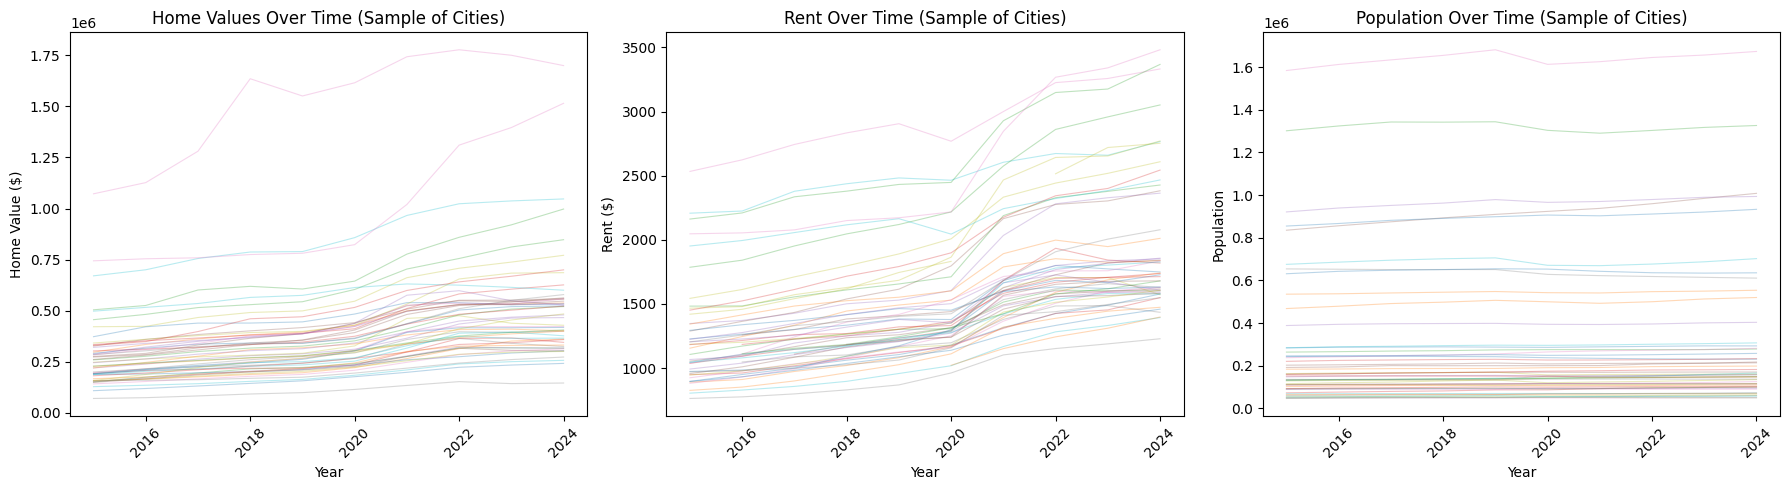

In [34]:
# Identify common years across all three factors
# Rent data starts from 2015, so that's our lowest common year
years = list(range(2015, 2025))

# Prepare data for scatter plots (levels)
home_cols = [str(y) + "_home" for y in years]
rent_cols = [str(y) + "_rent" for y in years]
pop_cols = [str(y) + "_pop" for y in years]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Home Values over time
for i, city in enumerate(merged.sample(min(50, len(merged)), random_state=42).index):
    row = merged.loc[city]
    axes[0].plot(years, [row[c] for c in home_cols], alpha=0.3, linewidth=0.8)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Home Value ($)')
axes[0].set_title('Home Values Over Time (Sample of Cities)')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Rent over time
for i, city in enumerate(merged.sample(min(50, len(merged)), random_state=42).index):
    row = merged.loc[city]
    axes[1].plot(years, [row[c] for c in rent_cols], alpha=0.3, linewidth=0.8)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Rent ($)')
axes[1].set_title('Rent Over Time (Sample of Cities)')
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: Population over time
for i, city in enumerate(merged.sample(min(50, len(merged)), random_state=42).index):
    row = merged.loc[city]
    axes[2].plot(years, [row[c] for c in pop_cols], alpha=0.3, linewidth=0.8)
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Population')
axes[2].set_title('Population Over Time (Sample of Cities)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

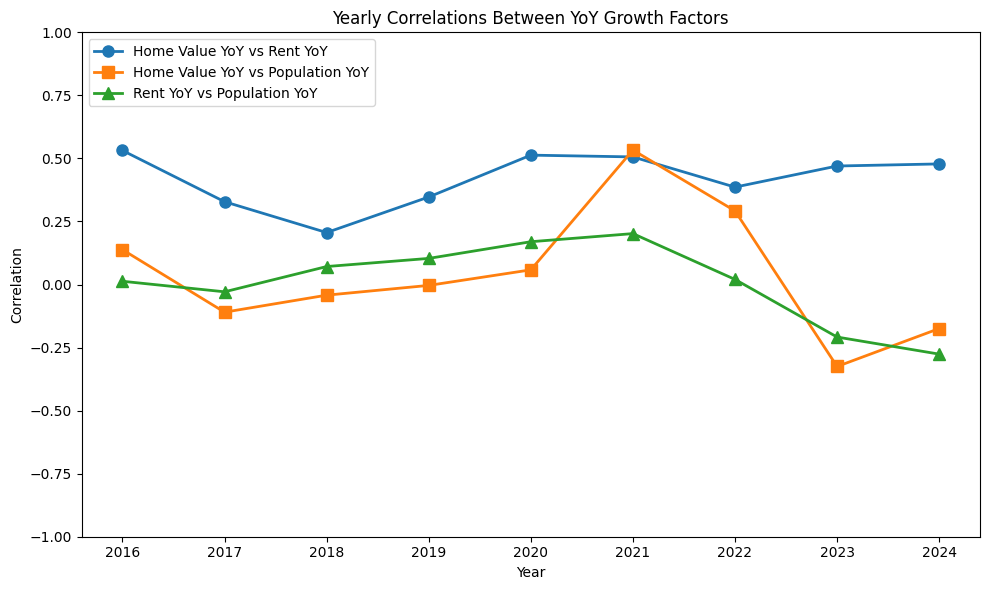

 Year  Home-Rent  Home-Pop  Rent-Pop   N
 2016   0.531530  0.138227  0.012919 221
 2017   0.328362 -0.109636 -0.028867 241
 2018   0.206061 -0.042176  0.071330 247
 2019   0.347125 -0.003490  0.103578 252
 2020   0.513061  0.058210  0.169747 253
 2021   0.506029  0.533270  0.201933 252
 2022   0.386233  0.292020  0.020223 255
 2023   0.469933 -0.324966 -0.208243 258
 2024   0.478242 -0.174579 -0.275963 258


In [38]:
# Yearly correlations between the three factors (YoY growth)
# Years where we have YoY data for all three factors
yoy_years = list(range(2016, 2025))

home_yoy_cols = [f"{y}_yoy_home" for y in yoy_years]
rent_yoy_cols = [f"{y}_yoy_rent" for y in yoy_years]
pop_yoy_cols = [f"{y}_yoy_pop" for y in yoy_years]

# Calculate yearly correlations
correlations = {
    'Year': yoy_years,
    'Home-Rent': [],
    'Home-Pop': [],
    'Rent-Pop': [],
    'N': []
}

for i, year in enumerate(yoy_years):
    home_col = home_yoy_cols[i]
    rent_col = rent_yoy_cols[i]
    pop_col = pop_yoy_cols[i]
    
    # Drop NaN values for correlation calculation
    valid_data = merged[[home_col, rent_col, pop_col]].dropna()
    
    correlations['Home-Rent'].append(valid_data[home_col].corr(valid_data[rent_col]))
    correlations['Home-Pop'].append(valid_data[home_col].corr(valid_data[pop_col]))
    correlations['Rent-Pop'].append(valid_data[rent_col].corr(valid_data[pop_col]))
    correlations['N'].append(len(valid_data))

corr_df = pd.DataFrame(correlations)

# Plot correlations over time
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(corr_df['Year'], corr_df['Home-Rent'], 'o-', label='Home Value YoY vs Rent YoY', linewidth=2, markersize=8)
ax1.plot(corr_df['Year'], corr_df['Home-Pop'], 's-', label='Home Value YoY vs Population YoY', linewidth=2, markersize=8)
ax1.plot(corr_df['Year'], corr_df['Rent-Pop'], '^-', label='Rent YoY vs Population YoY', linewidth=2, markersize=8)
ax1.set_xlabel('Year')
ax1.set_ylabel('Correlation')
ax1.set_title('Yearly Correlations Between YoY Growth Factors')
ax1.legend(loc='upper left')
ax1.set_ylim(-1, 1)



plt.tight_layout()
plt.show()

print(corr_df.to_string(index=False))

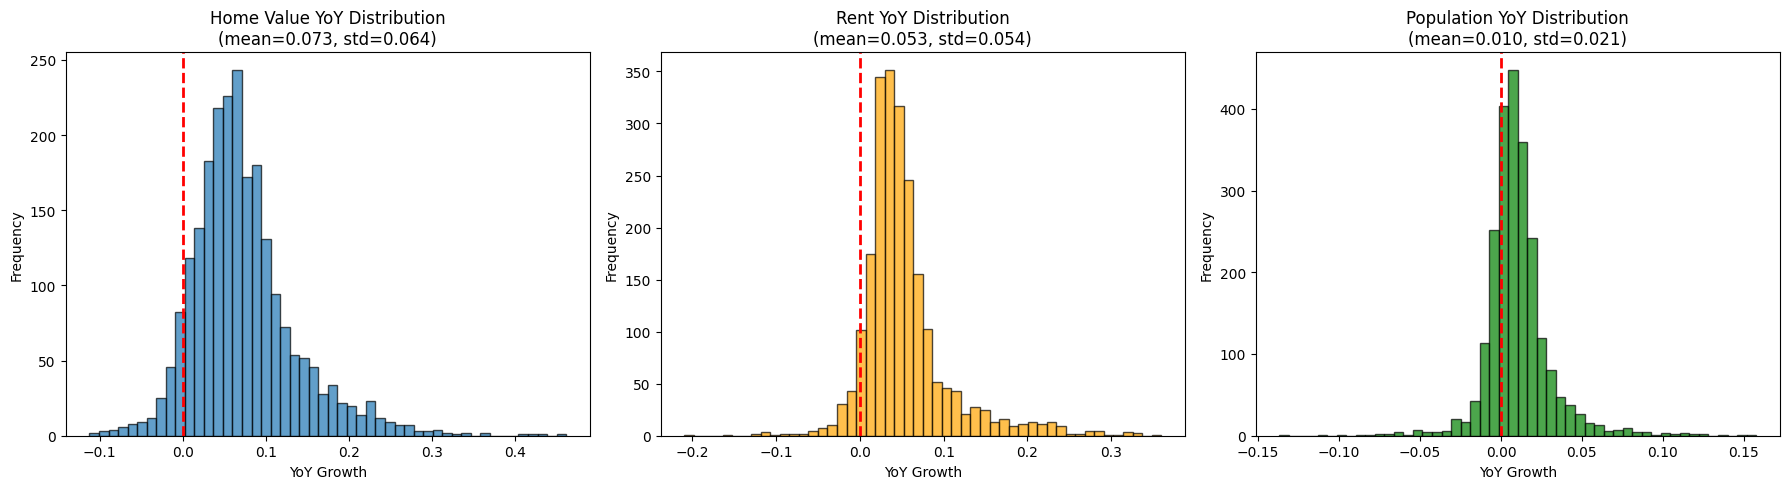

In [36]:
# Distribution of YoY growth for each factor
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Collect all YoY values for each factor
home_yoy_values = merged[home_yoy_cols].values.flatten()
home_yoy_values = home_yoy_values[~pd.isna(home_yoy_values)]

rent_yoy_values = merged[rent_yoy_cols].values.flatten()
rent_yoy_values = rent_yoy_values[~pd.isna(rent_yoy_values)]

pop_yoy_values = merged[pop_yoy_cols].values.flatten()
pop_yoy_values = pop_yoy_values[~pd.isna(pop_yoy_values)]

# Plot 1: Home Value YoY Distribution
axes[0].hist(home_yoy_values, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('YoY Growth')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Home Value YoY Distribution\n(mean={home_yoy_values.mean():.3f}, std={home_yoy_values.std():.3f})')

# Plot 2: Rent YoY Distribution
axes[1].hist(rent_yoy_values, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('YoY Growth')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Rent YoY Distribution\n(mean={rent_yoy_values.mean():.3f}, std={rent_yoy_values.std():.3f})')

# Plot 3: Population YoY Distribution
axes[2].hist(pop_yoy_values, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('YoY Growth')
axes[2].set_ylabel('Frequency')
axes[2].set_title(f'Population YoY Distribution\n(mean={pop_yoy_values.mean():.3f}, std={pop_yoy_values.std():.3f})')

plt.tight_layout()
plt.show()

### Normality check for population distributions

While it seems like the distribution could be normal, run statistical tests to confirm (more in Appendix):

In [39]:
# Normality tests for the three YoY distributions
from scipy import stats

print("Normality Tests for YoY Distributions")
print("=" * 60)

# Shapiro-Wilk test (best for smaller samples, but scipy limits to 5000)
# D'Agostino-Pearson test (good for larger samples)
# Kolmogorov-Smirnov test

def run_normality_tests(data, name):
    print(f"\n{name} (n={len(data)})")
    print("-" * 40)
    
    # Shapiro-Wilk (use sample if too large)
    if len(data) > 5000:
        sample = np.random.choice(data, 5000, replace=False)
        stat, p = stats.shapiro(sample)
        print(f"Shapiro-Wilk (n=5000 sample): stat={stat:.4f}, p={p:.2e}")
    else:
        stat, p = stats.shapiro(data)
        print(f"Shapiro-Wilk: stat={stat:.4f}, p={p:.2e}")
    
    # D'Agostino-Pearson (requires n >= 20)
    if len(data) >= 20:
        stat, p = stats.normaltest(data)
        print(f"D'Agostino-Pearson: stat={stat:.4f}, p={p:.2e}")
    
    # Kolmogorov-Smirnov test against normal distribution
    stat, p = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
    print(f"Kolmogorov-Smirnov: stat={stat:.4f}, p={p:.2e}")
    
    # Interpretation
    alpha = 0.05
    if p < alpha:
        print(f"→ Reject normality (p < {alpha})")
    else:
        print(f"→ Cannot reject normality (p >= {alpha})")

import numpy as np
run_normality_tests(home_yoy_values, "Home Value YoY")
run_normality_tests(rent_yoy_values, "Rent YoY")
run_normality_tests(pop_yoy_values, "Population YoY")

Normality Tests for YoY Distributions

Home Value YoY (n=2321)
----------------------------------------
Shapiro-Wilk: stat=0.9344, p=8.12e-31
D'Agostino-Pearson: stat=527.7647, p=2.50e-115
Kolmogorov-Smirnov: stat=0.0954, p=7.83e-19
→ Reject normality (p < 0.05)

Rent YoY (n=2238)
----------------------------------------
Shapiro-Wilk: stat=0.8386, p=6.51e-43
D'Agostino-Pearson: stat=838.7278, p=7.46e-183
Kolmogorov-Smirnov: stat=0.1586, p=1.22e-49
→ Reject normality (p < 0.05)

Population YoY (n=2322)
----------------------------------------
Shapiro-Wilk: stat=0.8599, p=2.22e-41
D'Agostino-Pearson: stat=651.5146, p=3.35e-142
Kolmogorov-Smirnov: stat=0.1214, p=2.84e-30
→ Reject normality (p < 0.05)


## Approach 1: OLS Regression

In [118]:
# Panel Regression Configuration
PANEL_CONFIG = {
    'outcome': 'rent',               # 'pop' or 'rent'
    'include_lagged_y': True,        # Include lagged outcome as predictor
    'fixed_effects': 'state',        # 'state', 'year', 'both', or None
    'test_years': [2024],            # Years to hold out for testing (recommend 1 year for forecasting)
    'regularization': 'ridge',       # 'ridge', 'lasso', 'elasticnet', or None (OLS)
    'alpha': 10.0,                    # Regularization strength (higher = more regularization)
}

print("Panel Regression Configuration:")
for k, v in PANEL_CONFIG.items():
    print(f"  {k}: {v}")

if PANEL_CONFIG['outcome'] == 'pop':
    print("\nModel: pop_yoy ~ rent_yoy + home_yoy + lagged_pop_yoy + FE")
else:
    print("\nModel: rent_yoy ~ pop_yoy + home_yoy + lagged_rent_yoy + FE")

Panel Regression Configuration:
  outcome: rent
  include_lagged_y: True
  fixed_effects: state
  test_years: [2024]
  regularization: ridge
  alpha: 10.0

Model: rent_yoy ~ pop_yoy + home_yoy + lagged_rent_yoy + FE


In [123]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Define outcome and covariate columns based on outcome choice
if PANEL_CONFIG['outcome'] == 'pop':
    outcome_cols = pop_yoy_cols
    outcome_name = 'Population YoY'
    # Covariates: rent + home
    cov1_cols = rent_yoy_cols
    cov2_cols = home_yoy_cols
    cov1_name = 'rent_yoy'
    cov2_name = 'home_yoy'
else:
    outcome_cols = rent_yoy_cols
    outcome_name = 'Rent YoY'
    # Covariates: pop + home
    cov1_cols = pop_yoy_cols
    cov2_cols = home_yoy_cols
    cov1_name = 'pop_yoy'
    cov2_name = 'home_yoy'

# Build panel dataset with lagged variables
panel_data = []

for idx, row in merged.iterrows():
    city = row['City']
    state = row['State']
    
    y_values = row[outcome_cols].values.astype(float)
    cov1_values = row[cov1_cols].values.astype(float)
    cov2_values = row[cov2_cols].values.astype(float)
    
    # Start from t=1 to have lagged values
    for t in range(1, len(yoy_years)):
        y_t = y_values[t]
        y_lag1 = y_values[t-1]
        cov1_t = cov1_values[t]
        cov1_lag1 = cov1_values[t-1]
        cov2_t = cov2_values[t]
        cov2_lag1 = cov2_values[t-1]
        
        # Skip if any NaN
        if pd.isna([y_t, y_lag1, cov1_t, cov1_lag1, cov2_t, cov2_lag1]).any():
            continue
            
        panel_data.append({
            'City': city,
            'State': state,
            'Year': yoy_years[t],
            'y': y_t,
            'y_lag1': y_lag1,
            cov1_name: cov1_t,
            f'{cov1_name}_lag1': cov1_lag1,
            cov2_name: cov2_t,
            f'{cov2_name}_lag1': cov2_lag1
        })

panel_df = pd.DataFrame(panel_data)
print(f"Panel dataset: {len(panel_df)} observations")
print(f"  Cities: {len(panel_df['City'].unique())}")
print(f"  States: {len(panel_df['State'].unique())}")
print(f"  Years: {sorted(panel_df['Year'].unique())}")
print(f"\nOutcome: {outcome_name}")
print(f"Covariates: {cov1_name}, {cov2_name}")

Panel dataset: 1977 observations
  Cities: 255
  States: 38
  Years: [np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]

Outcome: Rent YoY
Covariates: pop_yoy, home_yoy


In [124]:
# Train/test split by year
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler

train_df = panel_df[~panel_df['Year'].isin(PANEL_CONFIG['test_years'])].copy()
test_df = panel_df[panel_df['Year'].isin(PANEL_CONFIG['test_years'])].copy()

print(f"Train set: {len(train_df)} observations (years {sorted(train_df['Year'].unique())})")
print(f"Test set: {len(test_df)} observations (years {sorted(test_df['Year'].unique())})")

# Build feature matrix
feature_cols = []

if PANEL_CONFIG['include_lagged_y']:
    feature_cols.append('y_lag1')

# Add covariate features
feature_cols.extend([cov1_name, f'{cov1_name}_lag1', cov2_name, f'{cov2_name}_lag1'])

print(f"\nBase features: {feature_cols}")

# Add fixed effects
fe_setting = PANEL_CONFIG['fixed_effects']
state_dummy_cols = []
year_dummy_cols = []

# State fixed effects
if fe_setting in ['state', 'both']:
    state_dummies = pd.get_dummies(panel_df['State'], prefix='state', drop_first=True).astype(int)
    panel_df = pd.concat([panel_df.reset_index(drop=True), state_dummies.reset_index(drop=True)], axis=1)
    state_dummy_cols = list(state_dummies.columns)
    print(f"State fixed effects: {len(state_dummy_cols)} dummy variables")

# Year fixed effects
if fe_setting in ['year', 'both']:
    year_dummies = pd.get_dummies(panel_df['Year'], prefix='year', drop_first=True).astype(int)
    panel_df = pd.concat([panel_df.reset_index(drop=True), year_dummies.reset_index(drop=True)], axis=1)
    year_dummy_cols = list(year_dummies.columns)
    print(f"Year fixed effects: {len(year_dummy_cols)} dummy variables")

# Update train/test with dummies
train_df = panel_df[~panel_df['Year'].isin(PANEL_CONFIG['test_years'])].copy()
test_df = panel_df[panel_df['Year'].isin(PANEL_CONFIG['test_years'])].copy()

all_feature_cols = feature_cols + state_dummy_cols + year_dummy_cols

# Prepare X and y
X_train = train_df[all_feature_cols].astype(float)
y_train = train_df['y'].astype(float)
X_test = test_df[all_feature_cols].astype(float)
y_test = test_df['y'].astype(float)

# Choose model based on regularization setting
reg_setting = PANEL_CONFIG.get('regularization', None)
reg_alpha = PANEL_CONFIG.get('alpha', 1.0)

if reg_setting in ['ridge', 'lasso', 'elasticnet']:
    # Standardize features for regularized models (important!)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    if reg_setting == 'ridge':
        reg_model = Ridge(alpha=reg_alpha)
    elif reg_setting == 'lasso':
        reg_model = Lasso(alpha=reg_alpha)
    else:  # elasticnet
        reg_model = ElasticNet(alpha=reg_alpha, l1_ratio=0.5)
    
    reg_model.fit(X_train_scaled, y_train)
    
    # Create coefficient series for compatibility
    coef_values = np.concatenate([[reg_model.intercept_], reg_model.coef_])
    coef_names = ['const'] + all_feature_cols
    
    print("\n" + "=" * 60)
    print(f"Model: {reg_setting.upper()} (α={reg_alpha}) with {fe_setting} fixed effects")
    print(f"N observations: {len(y_train)}")
    print(f"N features: {len(all_feature_cols)}")
    print("=" * 60)
    
    # Print main coefficients
    print("\nMain Coefficients (standardized):")
    for i, feat in enumerate(['const'] + feature_cols):
        idx = coef_names.index(feat)
        coef = coef_values[idx]
        print(f"  {feat:20s}: {coef:8.4f}")
    
    # For predictions
    y_pred_train = reg_model.predict(X_train_scaled)
    y_pred_test = reg_model.predict(X_test_scaled)
    
    # Store for later use
    model_type = 'sklearn'
    
else:
    # OLS (no regularization)
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    
    model = sm.OLS(y_train, X_train_const).fit()
    
    print("\n" + "=" * 60)
    print(f"Model: OLS with {fe_setting} fixed effects")
    print(f"N observations: {len(y_train)}")
    print(f"N features: {len(all_feature_cols)} + constant")
    print("=" * 60)
    
    # Print only the main coefficients (not all state/year dummies)
    print("\nMain Coefficients:")
    for feat in ['const'] + feature_cols:
        if feat in model.params.index:
            coef = model.params[feat]
            se = model.bse[feat]
            pval = model.pvalues[feat]
            sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
            print(f"  {feat:20s}: {coef:8.4f} (SE: {se:.4f}, p: {pval:.4f}) {sig}")
    
    # Print year FE coefficients if included
    if year_dummy_cols:
        print("\nYear Fixed Effects:")
        for feat in year_dummy_cols:
            if feat in model.params.index:
                coef = model.params[feat]
                pval = model.pvalues[feat]
                sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
                print(f"  {feat:20s}: {coef:8.4f} {sig}")
    
    print(f"\nR² (train): {model.rsquared:.4f}")
    print(f"Adj R² (train): {model.rsquared_adj:.4f}")
    
    y_pred_train = model.predict(X_train_const)
    y_pred_test = model.predict(X_test_const)
    
    model_type = 'statsmodels'

Train set: 1719 observations (years [np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)])
Test set: 258 observations (years [np.int64(2024)])

Base features: ['y_lag1', 'pop_yoy', 'pop_yoy_lag1', 'home_yoy', 'home_yoy_lag1']
State fixed effects: 37 dummy variables

Model: RIDGE (α=10.0) with state fixed effects
N observations: 1719
N features: 42

Main Coefficients (standardized):
  const               :   0.0587
  y_lag1              :  -0.0122
  pop_yoy             :  -0.0003
  pop_yoy_lag1        :  -0.0027
  home_yoy            :   0.0382
  home_yoy_lag1       :   0.0089


Panel Regression Results for Rent YoY
Fixed Effects: state

Training Performance:
  R²: 0.4787
  RMSE: 0.0419
  MAE: 0.0295

Test Performance:
  R²: -0.0313
  RMSE: 0.0227
  MAE: 0.0179


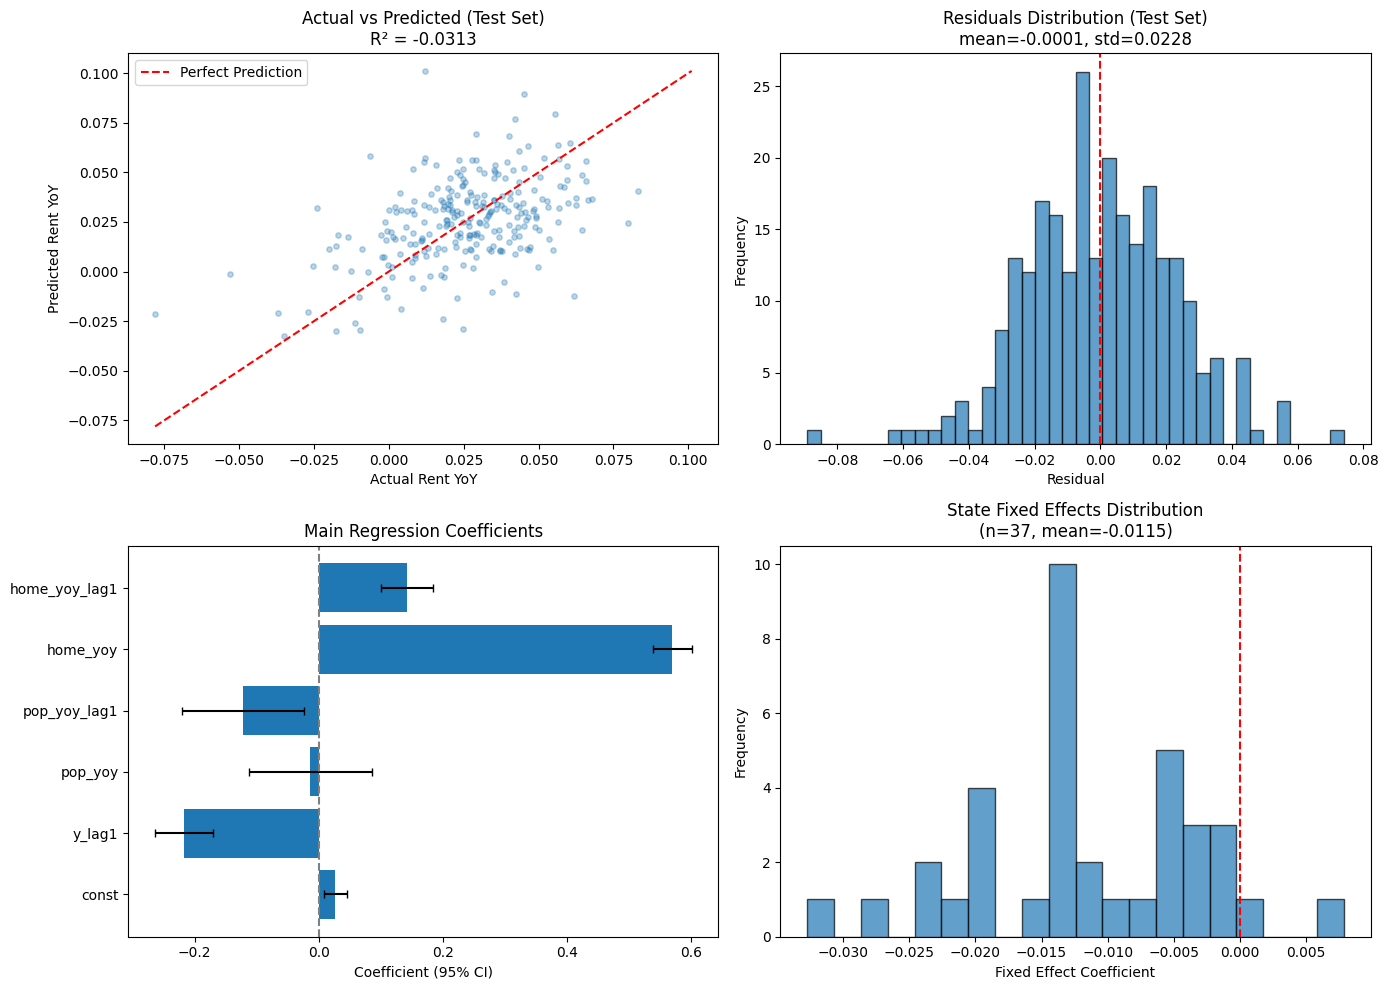

In [125]:
# Evaluate panel regression performance
y_pred_train = model.predict(X_train_const)
y_pred_test = model.predict(X_test_const)

fe_setting = PANEL_CONFIG['fixed_effects']

print(f"Panel Regression Results for {outcome_name}")
print(f"Fixed Effects: {fe_setting}")
print("=" * 60)

print(f"\nTraining Performance:")
print(f"  R²: {r2_score(y_train, y_pred_train):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"  MAE: {mean_absolute_error(y_train, y_pred_train):.4f}")

print(f"\nTest Performance:")
print(f"  R²: {r2_score(y_test, y_pred_test):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")

# Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Actual vs Predicted (Test set)
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.3, s=15)
min_val, max_val = min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
axes[0, 0].set_xlabel(f'Actual {outcome_name}')
axes[0, 0].set_ylabel(f'Predicted {outcome_name}')
axes[0, 0].set_title(f'Actual vs Predicted (Test Set)\nR² = {r2_score(y_test, y_pred_test):.4f}')
axes[0, 0].legend()

# Residuals distribution
residuals = y_test - y_pred_test
axes[0, 1].hist(residuals, bins=40, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Residuals Distribution (Test Set)\nmean={residuals.mean():.4f}, std={residuals.std():.4f}')

# Main coefficients plot (excluding state/year dummies)
main_coefs = model.params[['const'] + feature_cols]
main_se = model.bse[['const'] + feature_cols]
axes[1, 0].barh(range(len(main_coefs)), main_coefs.values, xerr=1.96*main_se.values, capsize=3)
axes[1, 0].set_yticks(range(len(main_coefs)))
axes[1, 0].set_yticklabels(main_coefs.index)
axes[1, 0].axvline(x=0, color='gray', linestyle='--')
axes[1, 0].set_xlabel('Coefficient (95% CI)')
axes[1, 0].set_title('Main Regression Coefficients')

# Fixed effects visualization
if fe_setting == 'both':
    # Show year FE as bar chart
    year_coefs = model.params[[c for c in model.params.index if c.startswith('year_')]]
    years = [int(c.split('_')[1]) for c in year_coefs.index]
    axes[1, 1].bar(years, year_coefs.values, color='steelblue', edgecolor='black')
    axes[1, 1].axhline(y=0, color='red', linestyle='--')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Fixed Effect Coefficient')
    axes[1, 1].set_title(f'Year Fixed Effects\n(relative to {min(panel_df["Year"])})')
elif fe_setting == 'state':
    state_coefs = model.params[[c for c in model.params.index if c.startswith('state_')]]
    axes[1, 1].hist(state_coefs, bins=20, edgecolor='black', alpha=0.7)
    axes[1, 1].axvline(x=0, color='red', linestyle='--')
    axes[1, 1].set_xlabel('Fixed Effect Coefficient')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title(f'State Fixed Effects Distribution\n(n={len(state_coefs)}, mean={state_coefs.mean():.4f})')
elif fe_setting == 'year':
    year_coefs = model.params[[c for c in model.params.index if c.startswith('year_')]]
    years = [int(c.split('_')[1]) for c in year_coefs.index]
    axes[1, 1].bar(years, year_coefs.values, color='steelblue', edgecolor='black')
    axes[1, 1].axhline(y=0, color='red', linestyle='--')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Fixed Effect Coefficient')
    axes[1, 1].set_title(f'Year Fixed Effects\n(relative to {min(panel_df["Year"])})')
else:
    axes[1, 1].text(0.5, 0.5, 'No fixed effects', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Fixed Effects')

plt.tight_layout()
plt.show()

Time-Series Cross-Validation Results (State FE only)
 Test Year Train Years  N Train  N Test  R² (OOS)   RMSE    MAE
      2020   2017-2019      709     252    0.0837 0.0489 0.0328
      2021   2017-2020      961     251   -2.2667 0.1183 0.1028
      2022   2017-2021     1212     252   -0.9450 0.0490 0.0388
      2023   2017-2022     1464     255   -0.9493 0.0339 0.0268
      2024   2017-2023     1719     258   -0.0313 0.0227 0.0179

Average OOS R²: -0.8217
Average RMSE: 0.0546


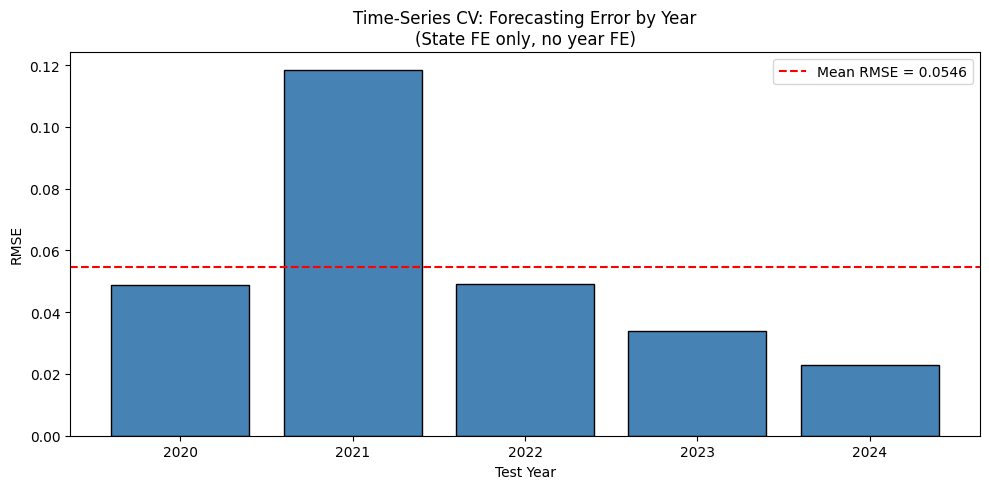

In [126]:
# Time-Series Cross-Validation: Train on years up to t, test on year t+1
# This gives a better picture of true forecasting performance

cv_results = []
test_year_range = range(2020, 2025)  # Test on 2020, 2021, 2022, 2023, 2024

for test_year in test_year_range:
    # Train on all years before test_year
    cv_train = panel_df[panel_df['Year'] < test_year].copy()
    cv_test = panel_df[panel_df['Year'] == test_year].copy()
    
    if len(cv_train) < 50 or len(cv_test) < 10:
        continue
    
    # Use only state FE for fair OOS comparison (no year FE leakage)
    cv_feature_cols = feature_cols + state_dummy_cols
    
    X_cv_train = cv_train[cv_feature_cols].astype(float)
    y_cv_train = cv_train['y'].astype(float)
    X_cv_test = cv_test[cv_feature_cols].astype(float)
    y_cv_test = cv_test['y'].astype(float)
    
    X_cv_train_const = sm.add_constant(X_cv_train)
    X_cv_test_const = sm.add_constant(X_cv_test)
    
    cv_model = sm.OLS(y_cv_train, X_cv_train_const).fit()
    y_cv_pred = cv_model.predict(X_cv_test_const)
    
    cv_results.append({
        'Test Year': test_year,
        'Train Years': f"2017-{test_year-1}",
        'N Train': len(cv_train),
        'N Test': len(cv_test),
        'R² (OOS)': r2_score(y_cv_test, y_cv_pred),
        'RMSE': np.sqrt(mean_squared_error(y_cv_test, y_cv_pred)),
        'MAE': mean_absolute_error(y_cv_test, y_cv_pred)
    })

cv_df = pd.DataFrame(cv_results)

print("Time-Series Cross-Validation Results (State FE only)")
print("=" * 80)
print(cv_df.to_string(index=False, float_format=lambda x: f'{x:.4f}' if isinstance(x, float) else x))

print(f"\nAverage OOS R²: {cv_df['R² (OOS)'].mean():.4f}")
print(f"Average RMSE: {cv_df['RMSE'].mean():.4f}")

# Plot CV results - RMSE
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(cv_df['Test Year'], cv_df['RMSE'], color='steelblue', edgecolor='black')
ax.set_xlabel('Test Year')
ax.set_ylabel('RMSE')
ax.set_title('Time-Series CV: Forecasting Error by Year\n(State FE only, no year FE)')
ax.axhline(y=cv_df['RMSE'].mean(), color='red', linestyle='--', label=f'Mean RMSE = {cv_df["RMSE"].mean():.4f}')
ax.legend()
plt.tight_layout()
plt.show()

## Approach 2: Neural Network

In [137]:
# Fully Connected Neural Network for Forecasting
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Configuration
NN_CONFIG = {
    'hidden_layers': [512, 256, 256, 128, 128, 64, 32],  # Deep network with 7 hidden layers
    'dropout': 0.3,                        # Increased dropout for deeper network
    'learning_rate': 0.0005,               # Lower LR for stability
    'epochs': 300,
    'batch_size': 32,
    'early_stopping_patience': 30,
}

print("Neural Network Configuration:")
for k, v in NN_CONFIG.items():
    print(f"  {k}: {v}")

# Use the same panel_df and feature_cols from OLS section
# But we'll use only the numeric features (no state dummies for simplicity, or include them)
use_state_fe = True  # Set to True to include state fixed effects

if use_state_fe:
    nn_feature_cols = feature_cols + state_dummy_cols
else:
    nn_feature_cols = feature_cols

print(f"\nFeatures: {len(nn_feature_cols)} columns")
print(f"  Base features: {feature_cols}")
if use_state_fe:
    print(f"  + {len(state_dummy_cols)} state dummies")

Neural Network Configuration:
  hidden_layers: [512, 256, 256, 128, 128, 64, 32]
  dropout: 0.3
  learning_rate: 0.0005
  epochs: 300
  batch_size: 32
  early_stopping_patience: 30

Features: 42 columns
  Base features: ['y_lag1', 'pop_yoy', 'pop_yoy_lag1', 'home_yoy', 'home_yoy_lag1']
  + 37 state dummies


In [138]:
# Prepare data for neural network
# Use same train/test split as OLS (by year)
test_years_nn = [2024]

nn_train_df = panel_df[~panel_df['Year'].isin(test_years_nn)].copy()
nn_test_df = panel_df[panel_df['Year'].isin(test_years_nn)].copy()

X_nn_train = nn_train_df[nn_feature_cols].astype(float).values
y_nn_train = nn_train_df['y'].astype(float).values
X_nn_test = nn_test_df[nn_feature_cols].astype(float).values
y_nn_test = nn_test_df['y'].astype(float).values

# Standardize features
scaler_nn = StandardScaler()
X_nn_train_scaled = scaler_nn.fit_transform(X_nn_train)
X_nn_test_scaled = scaler_nn.transform(X_nn_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_nn_train_scaled)
y_train_tensor = torch.FloatTensor(y_nn_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_nn_test_scaled)
y_test_tensor = torch.FloatTensor(y_nn_test).unsqueeze(1)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=NN_CONFIG['batch_size'], shuffle=True)

print(f"Train set: {len(X_nn_train)} samples")
print(f"Test set: {len(X_nn_test)} samples")
print(f"Input dimension: {X_nn_train.shape[1]}")

Train set: 1719 samples
Test set: 258 samples
Input dimension: 42


In [139]:
# Define the FCNN model
class ForecastingFCNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout=0.2):
        super(ForecastingFCNN, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer (single value for regression)
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Initialize model
input_dim = X_nn_train.shape[1]
model_nn = ForecastingFCNN(
    input_dim=input_dim,
    hidden_layers=NN_CONFIG['hidden_layers'],
    dropout=NN_CONFIG['dropout']
)

print(model_nn)
print(f"\nTotal parameters: {sum(p.numel() for p in model_nn.parameters()):,}")

ForecastingFCNN(
  (network): Sequential(
    (0): Linear(in_features=42, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=128, out_features=64, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.3, inplace=False)
    (18): Linear(in_features=64, out_features=32, bias=True)
    (19): ReLU()
    (20): Dropout(p=0.3, inplace=False)
    (21): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 278,913


In [140]:
# Training loop with early stopping
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=NN_CONFIG['learning_rate'])

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(NN_CONFIG['epochs']):
    # Training
    model_nn.train()
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model_nn(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * len(X_batch)
    
    epoch_train_loss /= len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation (using test set for simplicity - in practice use a separate val set)
    model_nn.eval()
    with torch.no_grad():
        y_val_pred = model_nn(X_test_tensor)
        val_loss = criterion(y_val_pred, y_test_tensor).item()
    val_losses.append(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model_nn.state_dict().copy()
    else:
        patience_counter += 1
    
    if patience_counter >= NN_CONFIG['early_stopping_patience']:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{NN_CONFIG['epochs']}: Train Loss = {epoch_train_loss:.6f}, Val Loss = {val_loss:.6f}")

# Load best model
model_nn.load_state_dict(best_model_state)
print(f"\nBest validation loss: {best_val_loss:.6f}")

Epoch 20/300: Train Loss = 0.001282, Val Loss = 0.001035
Epoch 40/300: Train Loss = 0.001050, Val Loss = 0.000649
Epoch 40/300: Train Loss = 0.001050, Val Loss = 0.000649
Early stopping at epoch 47

Best validation loss: 0.000467
Early stopping at epoch 47

Best validation loss: 0.000467


FCNN Results

Training Performance:
  R²: 0.7951
  RMSE: 0.0263
  MAE: 0.0190

Test Performance:
  R²: -0.2117
  RMSE: 0.0247
  MAE: 0.0195

Comparison: OLS vs FCNN (Test Set)
Model              R²       RMSE
OLS           -0.0313     0.0227
FCNN          -0.2117     0.0247


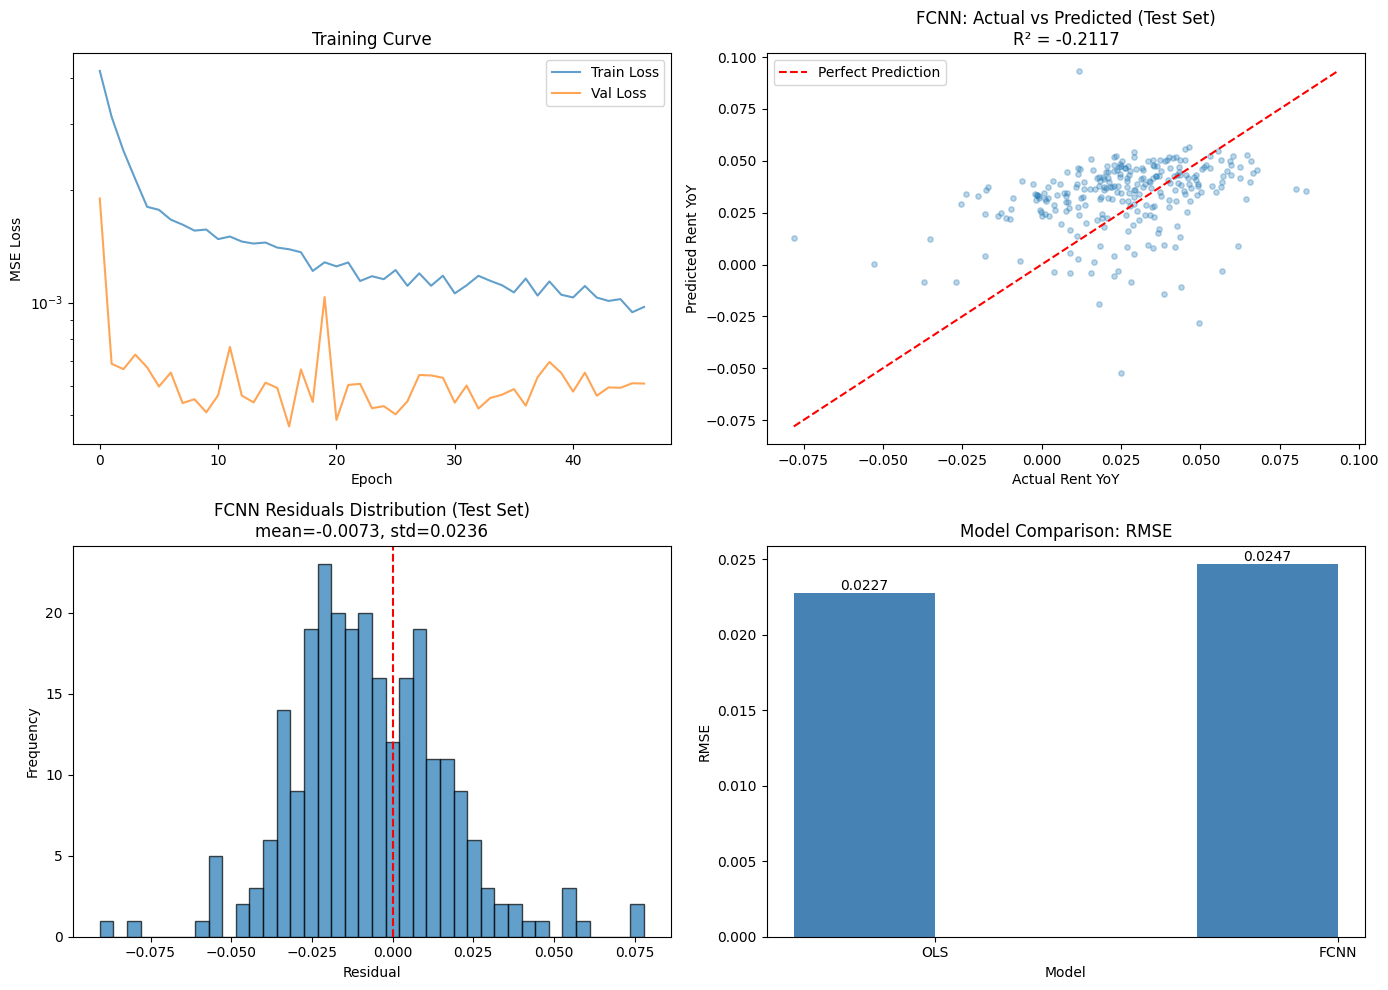

In [141]:
# Evaluate FCNN performance
model_nn.eval()
with torch.no_grad():
    y_nn_pred_train = model_nn(X_train_tensor).numpy().flatten()
    y_nn_pred_test = model_nn(X_test_tensor).numpy().flatten()

print("FCNN Results")
print("=" * 60)

print(f"\nTraining Performance:")
print(f"  R²: {r2_score(y_nn_train, y_nn_pred_train):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_nn_train, y_nn_pred_train)):.4f}")
print(f"  MAE: {mean_absolute_error(y_nn_train, y_nn_pred_train):.4f}")

print(f"\nTest Performance:")
print(f"  R²: {r2_score(y_nn_test, y_nn_pred_test):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_nn_test, y_nn_pred_test)):.4f}")
print(f"  MAE: {mean_absolute_error(y_nn_test, y_nn_pred_test):.4f}")

# Comparison with OLS
print("\n" + "=" * 60)
print("Comparison: OLS vs FCNN (Test Set)")
print("=" * 60)
ols_r2 = r2_score(y_test, y_pred_test)
ols_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
nn_r2 = r2_score(y_nn_test, y_nn_pred_test)
nn_rmse = np.sqrt(mean_squared_error(y_nn_test, y_nn_pred_test))

print(f"{'Model':<10} {'R²':>10} {'RMSE':>10}")
print(f"{'OLS':<10} {ols_r2:>10.4f} {ols_rmse:>10.4f}")
print(f"{'FCNN':<10} {nn_r2:>10.4f} {nn_rmse:>10.4f}")

# Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training curve
axes[0, 0].plot(train_losses, label='Train Loss', alpha=0.7)
axes[0, 0].plot(val_losses, label='Val Loss', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('Training Curve')
axes[0, 0].legend()
axes[0, 0].set_yscale('log')

# Actual vs Predicted (Test set)
axes[0, 1].scatter(y_nn_test, y_nn_pred_test, alpha=0.3, s=15)
min_val, max_val = min(y_nn_test.min(), y_nn_pred_test.min()), max(y_nn_test.max(), y_nn_pred_test.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
axes[0, 1].set_xlabel(f'Actual {outcome_name}')
axes[0, 1].set_ylabel(f'Predicted {outcome_name}')
axes[0, 1].set_title(f'FCNN: Actual vs Predicted (Test Set)\nR² = {nn_r2:.4f}')
axes[0, 1].legend()

# Residuals distribution
nn_residuals = y_nn_test - y_nn_pred_test
axes[1, 0].hist(nn_residuals, bins=40, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Residual')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'FCNN Residuals Distribution (Test Set)\nmean={nn_residuals.mean():.4f}, std={nn_residuals.std():.4f}')

# Model comparison bar chart
models = ['OLS', 'FCNN']
r2_scores = [ols_r2, nn_r2]
rmse_scores = [ols_rmse, nn_rmse]

x = np.arange(len(models))
width = 0.35

ax2 = axes[1, 1]
bars1 = ax2.bar(x - width/2, rmse_scores, width, label='RMSE', color='steelblue')
ax2.set_ylabel('RMSE')
ax2.set_xlabel('Model')
ax2.set_title('Model Comparison: RMSE')
ax2.set_xticks(x)
ax2.set_xticklabels(models)

# Add value labels
for bar, val in zip(bars1, rmse_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.4f}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Approach 3: LSTM Model

LSTMs are designed for sequential data and can capture temporal dependencies better than FCNNs.

In [166]:
# LSTM Configuration - Scaled to match FCNN size (~300K parameters)
LSTM_CONFIG = {
    'hidden_size': 256,         # Large LSTM hidden state size
    'num_layers': 3,            # More stacked LSTM layers
    'dropout': 0.3,             # Increased dropout for larger network
    'fc_layers': [256, 128, 64, 32],  # Deep FC layers after LSTM to match FCNN depth
    'learning_rate': 0.0005,    # Lower LR for stability with larger network
    'epochs': 300,
    'batch_size': 32,
    'early_stopping_patience': 30,
    'seq_length': 3,            # Number of time steps to look back
}

print("LSTM Configuration:")
for k, v in LSTM_CONFIG.items():
    print(f"  {k}: {v}")

LSTM Configuration:
  hidden_size: 256
  num_layers: 3
  dropout: 0.3
  fc_layers: [256, 128, 64, 32]
  learning_rate: 0.0005
  epochs: 300
  batch_size: 32
  early_stopping_patience: 30
  seq_length: 3


In [168]:
# Prepare sequential data for LSTM
# For each city, create sequences of consecutive years

seq_length = LSTM_CONFIG['seq_length']

# Build sequences from the merged dataframe
# Features at each time step: outcome_yoy, cov1_yoy, cov2_yoy (and optionally state encoding)
sequences = []
targets = []
city_ids = []
test_mask = []

# Get state one-hot encoding
state_encoder = {state: i for i, state in enumerate(merged['State'].unique())}
n_states = len(state_encoder)

for idx, row in merged.iterrows():
    city = row['City']
    state = row['State']
    state_idx = state_encoder[state]
    
    # Get time series for this city
    y_series = row[outcome_cols].values.astype(float)
    cov1_series = row[cov1_cols].values.astype(float)
    cov2_series = row[cov2_cols].values.astype(float)
    
    # Create sequences
    for t in range(seq_length, len(yoy_years)):
        # Check if we have valid data for the sequence
        seq_y = y_series[t-seq_length:t]
        seq_cov1 = cov1_series[t-seq_length:t]
        seq_cov2 = cov2_series[t-seq_length:t]
        target_y = y_series[t]
        
        # Skip if any NaN in sequence or target
        if np.any(np.isnan(seq_y)) or np.any(np.isnan(seq_cov1)) or np.any(np.isnan(seq_cov2)) or np.isnan(target_y):
            continue
        
        # Stack features: [y, cov1, cov2] for each time step
        # Shape: (seq_length, n_features)
        seq_features = np.column_stack([seq_y, seq_cov1, seq_cov2])
        
        sequences.append(seq_features)
        targets.append(target_y)
        city_ids.append(city)
        test_mask.append(yoy_years[t] in [2024])  # Test year

sequences = np.array(sequences)
targets = np.array(targets)
test_mask = np.array(test_mask)

print(f"Total sequences: {len(sequences)}")
print(f"Sequence shape: {sequences.shape}")  # (n_samples, seq_length, n_features)
print(f"Train sequences: {(~test_mask).sum()}")
print(f"Test sequences: {test_mask.sum()}")

Total sequences: 1460
Sequence shape: (1460, 3, 3)
Train sequences: 1208
Test sequences: 252


In [169]:
# Split and scale data
X_lstm_train = sequences[~test_mask]
y_lstm_train = targets[~test_mask]
X_lstm_test = sequences[test_mask]
y_lstm_test = targets[test_mask]

# Normalize features (reshape to 2D, scale, reshape back)
n_train, seq_len, n_feat = X_lstm_train.shape
n_test = X_lstm_test.shape[0]

scaler_lstm = StandardScaler()
X_lstm_train_flat = X_lstm_train.reshape(-1, n_feat)
X_lstm_train_scaled = scaler_lstm.fit_transform(X_lstm_train_flat).reshape(n_train, seq_len, n_feat)

X_lstm_test_flat = X_lstm_test.reshape(-1, n_feat)
X_lstm_test_scaled = scaler_lstm.transform(X_lstm_test_flat).reshape(n_test, seq_len, n_feat)

# Convert to PyTorch tensors
X_lstm_train_tensor = torch.FloatTensor(X_lstm_train_scaled)
y_lstm_train_tensor = torch.FloatTensor(y_lstm_train).unsqueeze(1)
X_lstm_test_tensor = torch.FloatTensor(X_lstm_test_scaled)
y_lstm_test_tensor = torch.FloatTensor(y_lstm_test).unsqueeze(1)

# Create DataLoader
lstm_train_dataset = TensorDataset(X_lstm_train_tensor, y_lstm_train_tensor)
lstm_train_loader = DataLoader(lstm_train_dataset, batch_size=LSTM_CONFIG['batch_size'], shuffle=True)

print(f"X_train shape: {X_lstm_train_tensor.shape}")  # (n_samples, seq_length, n_features)
print(f"X_test shape: {X_lstm_test_tensor.shape}")

X_train shape: torch.Size([1208, 3, 3])
X_test shape: torch.Size([252, 3, 3])


In [170]:
# Define LSTM model
class ForecastingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, fc_layers, dropout=0.2):
        super(ForecastingLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers after LSTM
        fc_input = hidden_size
        layers = []
        for fc_size in fc_layers:
            layers.append(nn.Linear(fc_input, fc_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            fc_input = fc_size
        
        # Output layer
        layers.append(nn.Linear(fc_input, 1))
        self.fc = nn.Sequential(*layers)
    
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Use the last hidden state
        last_hidden = lstm_out[:, -1, :]  # (batch, hidden_size)
        
        # Pass through FC layers
        output = self.fc(last_hidden)
        return output

# Initialize LSTM model
input_size = X_lstm_train.shape[2]  # Number of features per time step
model_lstm = ForecastingLSTM(
    input_size=input_size,
    hidden_size=LSTM_CONFIG['hidden_size'],
    num_layers=LSTM_CONFIG['num_layers'],
    fc_layers=LSTM_CONFIG['fc_layers'],
    dropout=LSTM_CONFIG['dropout']
)

print(model_lstm)
print(f"\nTotal parameters: {sum(p.numel() for p in model_lstm.parameters()):,}")

ForecastingLSTM(
  (lstm): LSTM(3, 256, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 1,428,993


In [ ]:
# Train LSTM
criterion_lstm = nn.MSELoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=LSTM_CONFIG['learning_rate'])

lstm_train_losses = []
lstm_val_losses = []
best_lstm_val_loss = float('inf')
lstm_patience_counter = 0

for epoch in range(LSTM_CONFIG['epochs']):
    # Training
    model_lstm.train()
    epoch_loss = 0
    for X_batch, y_batch in lstm_train_loader:
        optimizer_lstm.zero_grad()
        y_pred = model_lstm(X_batch)
        loss = criterion_lstm(y_pred, y_batch)
        loss.backward()
        optimizer_lstm.step()
        epoch_loss += loss.item() * len(X_batch)
    
    epoch_loss /= len(lstm_train_dataset)
    lstm_train_losses.append(epoch_loss)
    
    # Validation
    model_lstm.eval()
    with torch.no_grad():
        y_val_pred = model_lstm(X_lstm_test_tensor)
        val_loss = criterion_lstm(y_val_pred, y_lstm_test_tensor).item()
    lstm_val_losses.append(val_loss)
    
    # Early stopping
    if val_loss < best_lstm_val_loss:
        best_lstm_val_loss = val_loss
        lstm_patience_counter = 0
        best_lstm_state = model_lstm.state_dict().copy()
    else:
        lstm_patience_counter += 1
    
    if lstm_patience_counter >= LSTM_CONFIG['early_stopping_patience']:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{LSTM_CONFIG['epochs']}: Train Loss = {epoch_loss:.6f}, Val Loss = {val_loss:.6f}")

# Load best model
model_lstm.load_state_dict(best_lstm_state)
print(f"\nBest validation loss: {best_lstm_val_loss:.6f}")

Epoch 20/300: Train Loss = 0.002127, Val Loss = 0.001107


LSTM Results

Training Performance:
  R²: 0.6130
  RMSE: 0.0414
  MAE: 0.0283

Test Performance:
  R²: -1.4426
  RMSE: 0.0349
  MAE: 0.0259

Model Comparison (Test Set)
Model              R²       RMSE
OLS           -0.0313     0.0227
FCNN          -0.2117     0.0247
LSTM          -1.4426     0.0349


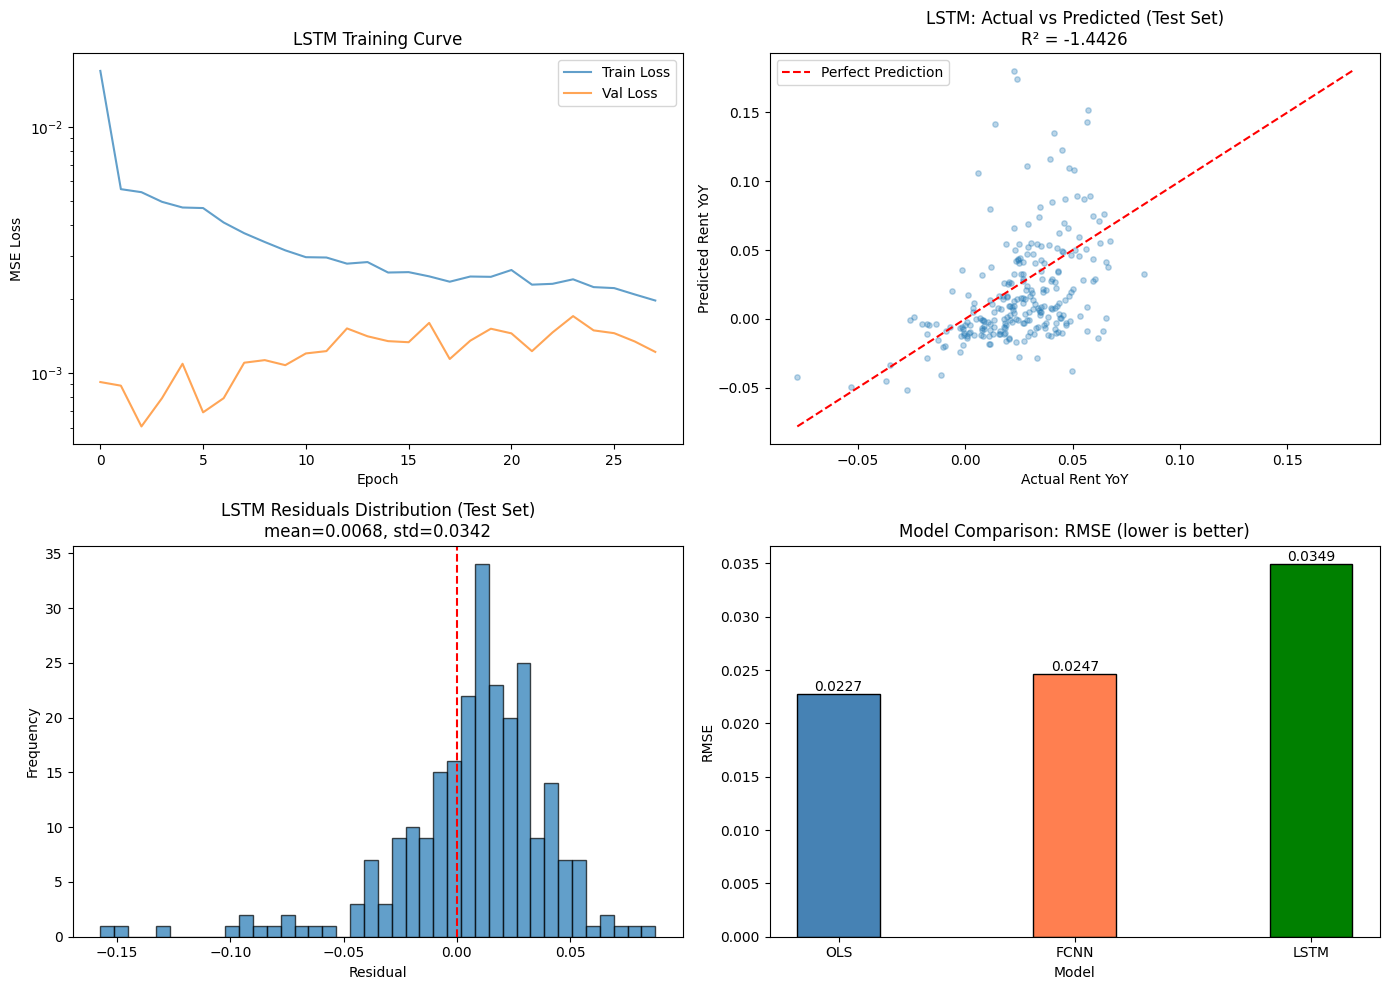

In [149]:
# Evaluate LSTM performance
model_lstm.eval()
with torch.no_grad():
    y_lstm_pred_train = model_lstm(X_lstm_train_tensor).numpy().flatten()
    y_lstm_pred_test = model_lstm(X_lstm_test_tensor).numpy().flatten()

print("LSTM Results")
print("=" * 60)

print(f"\nTraining Performance:")
print(f"  R²: {r2_score(y_lstm_train, y_lstm_pred_train):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_lstm_train, y_lstm_pred_train)):.4f}")
print(f"  MAE: {mean_absolute_error(y_lstm_train, y_lstm_pred_train):.4f}")

print(f"\nTest Performance:")
lstm_r2 = r2_score(y_lstm_test, y_lstm_pred_test)
lstm_rmse = np.sqrt(mean_squared_error(y_lstm_test, y_lstm_pred_test))
print(f"  R²: {lstm_r2:.4f}")
print(f"  RMSE: {lstm_rmse:.4f}")
print(f"  MAE: {mean_absolute_error(y_lstm_test, y_lstm_pred_test):.4f}")

# Comparison with all models
print("\n" + "=" * 60)
print("Model Comparison (Test Set)")
print("=" * 60)
print(f"{'Model':<10} {'R²':>10} {'RMSE':>10}")
print(f"{'OLS':<10} {ols_r2:>10.4f} {ols_rmse:>10.4f}")
print(f"{'FCNN':<10} {nn_r2:>10.4f} {nn_rmse:>10.4f}")
print(f"{'LSTM':<10} {lstm_r2:>10.4f} {lstm_rmse:>10.4f}")

# Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training curve
axes[0, 0].plot(lstm_train_losses, label='Train Loss', alpha=0.7)
axes[0, 0].plot(lstm_val_losses, label='Val Loss', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('LSTM Training Curve')
axes[0, 0].legend()
axes[0, 0].set_yscale('log')

# Actual vs Predicted (Test set)
axes[0, 1].scatter(y_lstm_test, y_lstm_pred_test, alpha=0.3, s=15)
min_val = min(y_lstm_test.min(), y_lstm_pred_test.min())
max_val = max(y_lstm_test.max(), y_lstm_pred_test.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
axes[0, 1].set_xlabel(f'Actual {outcome_name}')
axes[0, 1].set_ylabel(f'Predicted {outcome_name}')
axes[0, 1].set_title(f'LSTM: Actual vs Predicted (Test Set)\nR² = {lstm_r2:.4f}')
axes[0, 1].legend()

# Residuals distribution
lstm_residuals = y_lstm_test - y_lstm_pred_test
axes[1, 0].hist(lstm_residuals, bins=40, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Residual')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'LSTM Residuals Distribution (Test Set)\nmean={lstm_residuals.mean():.4f}, std={lstm_residuals.std():.4f}')

# Model comparison bar chart
models_all = ['OLS', 'FCNN', 'LSTM']
rmse_all = [ols_rmse, nn_rmse, lstm_rmse]
r2_all = [ols_r2, nn_r2, lstm_r2]

x = np.arange(len(models_all))
width = 0.35

bars = axes[1, 1].bar(x, rmse_all, width, color=['steelblue', 'coral', 'green'], edgecolor='black')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_title('Model Comparison: RMSE (lower is better)')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models_all)

# Add value labels
for bar, val in zip(bars, rmse_all):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.4f}', 
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Approach 4: Hybrid LSTM (Raw Values + Growth Rates)

This LSTM variant uses both raw values (levels) and YoY growth rates as input features, giving the model more context about absolute levels while still predicting growth directly.

**Features per time step:**
- Raw levels (normalized per-city): rent, home value, population
- YoY growth rates: rent_yoy, home_yoy, pop_yoy

This allows the LSTM to learn patterns like "high-rent cities grow differently" while maintaining stationarity in the target.

In [ ]:
# Hybrid LSTM Configuration - Scaled to match FCNN size (~300K parameters)
HYBRID_LSTM_CONFIG = {
    'hidden_size': 256,         # Large LSTM hidden state size
    'num_layers': 3,            # More stacked LSTM layers
    'dropout': 0.3,             # Dropout for regularization
    'fc_layers': [256, 128, 64, 32],  # Deep FC layers after LSTM to match FCNN depth
    'learning_rate': 0.0005,    # Lower LR for stability with larger network
    'epochs': 300,
    'batch_size': 32,
    'early_stopping_patience': 30,
    'seq_length': 3,            # Number of time steps to look back
}

print("Hybrid LSTM Configuration:")
for k, v in HYBRID_LSTM_CONFIG.items():
    print(f"  {k}: {v}")

Hybrid LSTM Configuration:
  hidden_size: 128
  num_layers: 2
  dropout: 0.3
  fc_layers: [64, 32]
  learning_rate: 0.001
  epochs: 300
  batch_size: 32
  early_stopping_patience: 30
  seq_length: 3


In [152]:
# Prepare hybrid data: raw values + growth rates
# For each city, we need both levels and YoY growth

seq_length_h = HYBRID_LSTM_CONFIG['seq_length']

# Define raw level columns (aligned with yoy_years which start at 2016)
# For YoY at year t, we use levels at year t
if PANEL_CONFIG['outcome'] == 'pop':
    outcome_level_cols = [f"{y}_pop" for y in yoy_years]
    cov1_level_cols = [f"{y}_rent" for y in yoy_years]
    cov2_level_cols = [f"{y}_home" for y in yoy_years]
else:
    outcome_level_cols = [f"{y}_rent" for y in yoy_years]
    cov1_level_cols = [f"{y}_pop" for y in yoy_years]
    cov2_level_cols = [f"{y}_home" for y in yoy_years]

# Build sequences with both raw levels and growth rates
hybrid_sequences = []
hybrid_targets = []
hybrid_city_ids = []
hybrid_test_mask = []

for idx, row in merged.iterrows():
    city = row['City']
    state = row['State']
    
    # Get time series for this city - both levels and growth
    y_levels = row[outcome_level_cols].values.astype(float)
    y_growth = row[outcome_cols].values.astype(float)
    
    cov1_levels = row[cov1_level_cols].values.astype(float)
    cov1_growth = row[cov1_cols].values.astype(float)
    
    cov2_levels = row[cov2_level_cols].values.astype(float)
    cov2_growth = row[cov2_cols].values.astype(float)
    
    # Normalize levels per-city (z-score) to handle scale differences
    # Only normalize if we have valid data
    if not np.all(np.isnan(y_levels)):
        y_levels_norm = (y_levels - np.nanmean(y_levels)) / (np.nanstd(y_levels) + 1e-8)
    else:
        y_levels_norm = y_levels
        
    if not np.all(np.isnan(cov1_levels)):
        cov1_levels_norm = (cov1_levels - np.nanmean(cov1_levels)) / (np.nanstd(cov1_levels) + 1e-8)
    else:
        cov1_levels_norm = cov1_levels
        
    if not np.all(np.isnan(cov2_levels)):
        cov2_levels_norm = (cov2_levels - np.nanmean(cov2_levels)) / (np.nanstd(cov2_levels) + 1e-8)
    else:
        cov2_levels_norm = cov2_levels
    
    # Create sequences
    for t in range(seq_length_h, len(yoy_years)):
        # Get sequence of features
        seq_y_level = y_levels_norm[t-seq_length_h:t]
        seq_y_growth = y_growth[t-seq_length_h:t]
        seq_cov1_level = cov1_levels_norm[t-seq_length_h:t]
        seq_cov1_growth = cov1_growth[t-seq_length_h:t]
        seq_cov2_level = cov2_levels_norm[t-seq_length_h:t]
        seq_cov2_growth = cov2_growth[t-seq_length_h:t]
        
        target_y = y_growth[t]  # Still predict growth!
        
        # Check for NaN in all features
        all_seq = np.concatenate([seq_y_level, seq_y_growth, seq_cov1_level, seq_cov1_growth, 
                                   seq_cov2_level, seq_cov2_growth])
        if np.any(np.isnan(all_seq)) or np.isnan(target_y):
            continue
        
        # Stack features: [y_level, y_growth, cov1_level, cov1_growth, cov2_level, cov2_growth]
        # Shape: (seq_length, 6 features)
        seq_features = np.column_stack([
            seq_y_level, seq_y_growth,
            seq_cov1_level, seq_cov1_growth,
            seq_cov2_level, seq_cov2_growth
        ])
        
        hybrid_sequences.append(seq_features)
        hybrid_targets.append(target_y)
        hybrid_city_ids.append(city)
        hybrid_test_mask.append(yoy_years[t] in [2024])

hybrid_sequences = np.array(hybrid_sequences)
hybrid_targets = np.array(hybrid_targets)
hybrid_test_mask = np.array(hybrid_test_mask)

print(f"Total hybrid sequences: {len(hybrid_sequences)}")
print(f"Sequence shape: {hybrid_sequences.shape}")  # (n_samples, seq_length, 6 features)
print(f"Features per timestep: y_level, y_growth, cov1_level, cov1_growth, cov2_level, cov2_growth")
print(f"Train sequences: {(~hybrid_test_mask).sum()}")
print(f"Test sequences: {hybrid_test_mask.sum()}")

Total hybrid sequences: 1460
Sequence shape: (1460, 3, 6)
Features per timestep: y_level, y_growth, cov1_level, cov1_growth, cov2_level, cov2_growth
Train sequences: 1208
Test sequences: 252


In [153]:
# Split and scale hybrid data
X_hybrid_train = hybrid_sequences[~hybrid_test_mask]
y_hybrid_train = hybrid_targets[~hybrid_test_mask]
X_hybrid_test = hybrid_sequences[hybrid_test_mask]
y_hybrid_test = hybrid_targets[hybrid_test_mask]

# Normalize features across the dataset (already normalized levels per-city, now normalize across samples)
n_train_h, seq_len_h, n_feat_h = X_hybrid_train.shape
n_test_h = X_hybrid_test.shape[0]

scaler_hybrid = StandardScaler()
X_hybrid_train_flat = X_hybrid_train.reshape(-1, n_feat_h)
X_hybrid_train_scaled = scaler_hybrid.fit_transform(X_hybrid_train_flat).reshape(n_train_h, seq_len_h, n_feat_h)

X_hybrid_test_flat = X_hybrid_test.reshape(-1, n_feat_h)
X_hybrid_test_scaled = scaler_hybrid.transform(X_hybrid_test_flat).reshape(n_test_h, seq_len_h, n_feat_h)

# Convert to PyTorch tensors
X_hybrid_train_tensor = torch.FloatTensor(X_hybrid_train_scaled)
y_hybrid_train_tensor = torch.FloatTensor(y_hybrid_train).unsqueeze(1)
X_hybrid_test_tensor = torch.FloatTensor(X_hybrid_test_scaled)
y_hybrid_test_tensor = torch.FloatTensor(y_hybrid_test).unsqueeze(1)

# Create DataLoader
hybrid_train_dataset = TensorDataset(X_hybrid_train_tensor, y_hybrid_train_tensor)
hybrid_train_loader = DataLoader(hybrid_train_dataset, batch_size=HYBRID_LSTM_CONFIG['batch_size'], shuffle=True)

print(f"X_train shape: {X_hybrid_train_tensor.shape}")  # (n_samples, seq_length, 6 features)
print(f"X_test shape: {X_hybrid_test_tensor.shape}")

X_train shape: torch.Size([1208, 3, 6])
X_test shape: torch.Size([252, 3, 6])


In [154]:
# Initialize Hybrid LSTM model (reuse ForecastingLSTM class)
input_size_h = X_hybrid_train.shape[2]  # 6 features per time step
model_hybrid = ForecastingLSTM(
    input_size=input_size_h,
    hidden_size=HYBRID_LSTM_CONFIG['hidden_size'],
    num_layers=HYBRID_LSTM_CONFIG['num_layers'],
    fc_layers=HYBRID_LSTM_CONFIG['fc_layers'],
    dropout=HYBRID_LSTM_CONFIG['dropout']
)

print(model_hybrid)
print(f"\nTotal parameters: {sum(p.numel() for p in model_hybrid.parameters()):,}")
print(f"\nInput features: 6 (3 levels + 3 growth rates) vs 3 (growth only) in basic LSTM")

ForecastingLSTM(
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 212,097

Input features: 6 (3 levels + 3 growth rates) vs 3 (growth only) in basic LSTM


In [155]:
# Train Hybrid LSTM
criterion_hybrid = nn.MSELoss()
optimizer_hybrid = optim.Adam(model_hybrid.parameters(), lr=HYBRID_LSTM_CONFIG['learning_rate'])

hybrid_train_losses = []
hybrid_val_losses = []
best_hybrid_val_loss = float('inf')
hybrid_patience_counter = 0

for epoch in range(HYBRID_LSTM_CONFIG['epochs']):
    # Training
    model_hybrid.train()
    epoch_loss = 0
    for X_batch, y_batch in hybrid_train_loader:
        optimizer_hybrid.zero_grad()
        y_pred = model_hybrid(X_batch)
        loss = criterion_hybrid(y_pred, y_batch)
        loss.backward()
        optimizer_hybrid.step()
        epoch_loss += loss.item() * len(X_batch)
    
    epoch_loss /= len(hybrid_train_dataset)
    hybrid_train_losses.append(epoch_loss)
    
    # Validation
    model_hybrid.eval()
    with torch.no_grad():
        y_val_pred = model_hybrid(X_hybrid_test_tensor)
        val_loss = criterion_hybrid(y_val_pred, y_hybrid_test_tensor).item()
    hybrid_val_losses.append(val_loss)
    
    # Early stopping
    if val_loss < best_hybrid_val_loss:
        best_hybrid_val_loss = val_loss
        hybrid_patience_counter = 0
        best_hybrid_state = model_hybrid.state_dict().copy()
    else:
        hybrid_patience_counter += 1
    
    if hybrid_patience_counter >= HYBRID_LSTM_CONFIG['early_stopping_patience']:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{HYBRID_LSTM_CONFIG['epochs']}: Train Loss = {epoch_loss:.6f}, Val Loss = {val_loss:.6f}")

# Load best model
model_hybrid.load_state_dict(best_hybrid_state)
print(f"\nBest validation loss: {best_hybrid_val_loss:.6f}")

Epoch 20/300: Train Loss = 0.001103, Val Loss = 0.000386
Epoch 40/300: Train Loss = 0.001045, Val Loss = 0.001662
Early stopping at epoch 53

Best validation loss: 0.000317


In [156]:
# Evaluate Hybrid LSTM performance
model_hybrid.eval()
with torch.no_grad():
    y_hybrid_pred_train = model_hybrid(X_hybrid_train_tensor).numpy().flatten()
    y_hybrid_pred_test = model_hybrid(X_hybrid_test_tensor).numpy().flatten()

print("Hybrid LSTM Results (Raw Values + Growth Rates)")
print("=" * 60)

print(f"\nTraining Performance:")
hybrid_train_r2 = r2_score(y_hybrid_train, y_hybrid_pred_train)
hybrid_train_rmse = np.sqrt(mean_squared_error(y_hybrid_train, y_hybrid_pred_train))
print(f"  R²: {hybrid_train_r2:.4f}")
print(f"  RMSE: {hybrid_train_rmse:.4f}")
print(f"  MAE: {mean_absolute_error(y_hybrid_train, y_hybrid_pred_train):.4f}")

print(f"\nTest Performance:")
hybrid_r2 = r2_score(y_hybrid_test, y_hybrid_pred_test)
hybrid_rmse = np.sqrt(mean_squared_error(y_hybrid_test, y_hybrid_pred_test))
print(f"  R²: {hybrid_r2:.4f}")
print(f"  RMSE: {hybrid_rmse:.4f}")
print(f"  MAE: {mean_absolute_error(y_hybrid_test, y_hybrid_pred_test):.4f}")

# Comparison with all models
print("\n" + "=" * 60)
print("Model Comparison (Test Set) - Including Hybrid LSTM")
print("=" * 60)
print(f"{'Model':<15} {'R²':>10} {'RMSE':>10} {'Features':>15}")
print("-" * 55)
print(f"{'OLS':<15} {ols_r2:>10.4f} {ols_rmse:>10.4f} {'lagged+covs':>15}")
print(f"{'FCNN':<15} {nn_r2:>10.4f} {nn_rmse:>10.4f} {'lagged+covs':>15}")
print(f"{'LSTM':<15} {lstm_r2:>10.4f} {lstm_rmse:>10.4f} {'growth only':>15}")
print(f"{'Hybrid LSTM':<15} {hybrid_r2:>10.4f} {hybrid_rmse:>10.4f} {'levels+growth':>15}")

# Highlight improvement
lstm_improvement = (hybrid_r2 - lstm_r2) / abs(lstm_r2) * 100 if lstm_r2 != 0 else 0
print(f"\nHybrid vs Basic LSTM: {lstm_improvement:+.1f}% R² change")

Hybrid LSTM Results (Raw Values + Growth Rates)

Training Performance:
  R²: 0.8819
  RMSE: 0.0228
  MAE: 0.0171

Test Performance:
  R²: -0.3969
  RMSE: 0.0264
  MAE: 0.0214

Model Comparison (Test Set) - Including Hybrid LSTM
Model                   R²       RMSE        Features
-------------------------------------------------------
OLS                -0.0313     0.0227     lagged+covs
FCNN               -0.2117     0.0247     lagged+covs
LSTM               -1.4426     0.0349     growth only
Hybrid LSTM        -0.3969     0.0264   levels+growth

Hybrid vs Basic LSTM: +72.5% R² change


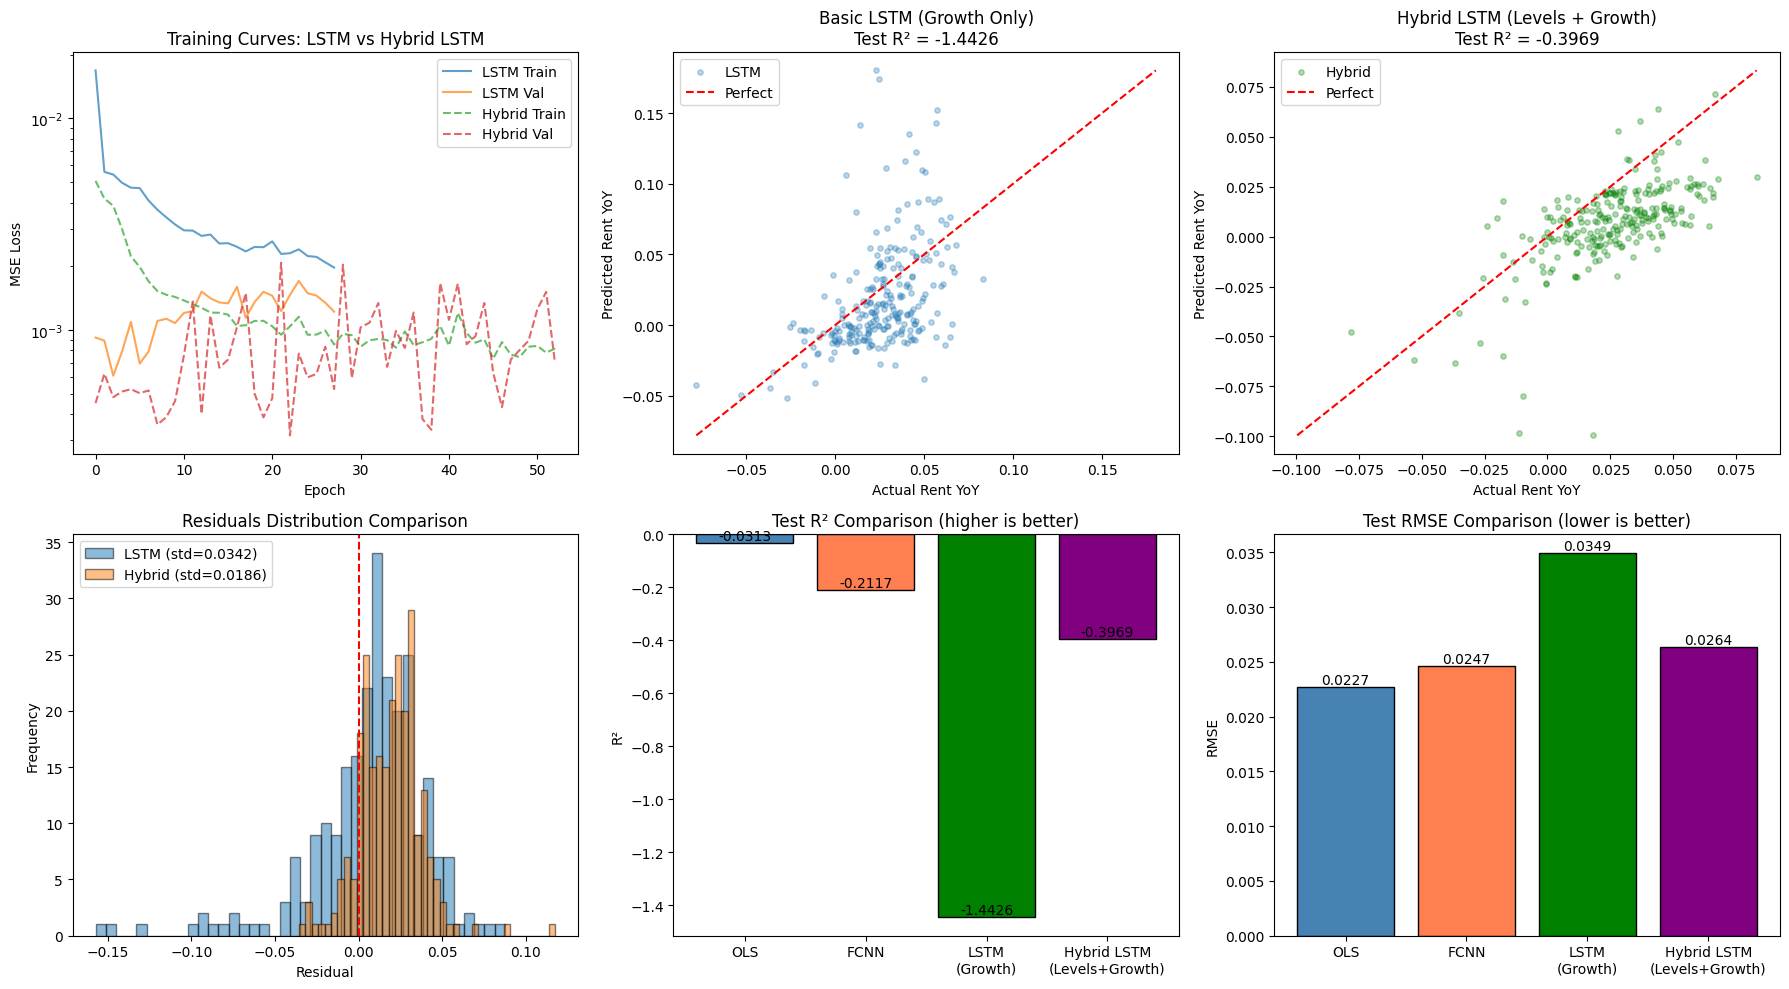


SUMMARY: Effect of Adding Raw Levels to LSTM

Basic LSTM (3 features: growth rates only):
  Test R²: -1.4426, RMSE: 0.0349

Hybrid LSTM (6 features: levels + growth rates):
  Test R²: -0.3969, RMSE: 0.0264

Difference:
  R² change: +1.0457
  RMSE change: -0.0085

✓ Adding raw levels IMPROVED performance by 72.5%


In [157]:
# Visualization: Compare LSTM vs Hybrid LSTM
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Training curves comparison
axes[0, 0].plot(lstm_train_losses, label='LSTM Train', alpha=0.7)
axes[0, 0].plot(lstm_val_losses, label='LSTM Val', alpha=0.7)
axes[0, 0].plot(hybrid_train_losses, label='Hybrid Train', alpha=0.7, linestyle='--')
axes[0, 0].plot(hybrid_val_losses, label='Hybrid Val', alpha=0.7, linestyle='--')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('Training Curves: LSTM vs Hybrid LSTM')
axes[0, 0].legend()
axes[0, 0].set_yscale('log')

# Actual vs Predicted - Basic LSTM
axes[0, 1].scatter(y_lstm_test, y_lstm_pred_test, alpha=0.3, s=15, label='LSTM')
min_val = min(y_lstm_test.min(), y_lstm_pred_test.min())
max_val = max(y_lstm_test.max(), y_lstm_pred_test.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect')
axes[0, 1].set_xlabel(f'Actual {outcome_name}')
axes[0, 1].set_ylabel(f'Predicted {outcome_name}')
axes[0, 1].set_title(f'Basic LSTM (Growth Only)\nTest R² = {lstm_r2:.4f}')
axes[0, 1].legend()

# Actual vs Predicted - Hybrid LSTM
axes[0, 2].scatter(y_hybrid_test, y_hybrid_pred_test, alpha=0.3, s=15, color='green', label='Hybrid')
min_val = min(y_hybrid_test.min(), y_hybrid_pred_test.min())
max_val = max(y_hybrid_test.max(), y_hybrid_pred_test.max())
axes[0, 2].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect')
axes[0, 2].set_xlabel(f'Actual {outcome_name}')
axes[0, 2].set_ylabel(f'Predicted {outcome_name}')
axes[0, 2].set_title(f'Hybrid LSTM (Levels + Growth)\nTest R² = {hybrid_r2:.4f}')
axes[0, 2].legend()

# Residuals comparison
lstm_residuals = y_lstm_test - y_lstm_pred_test
hybrid_residuals = y_hybrid_test - y_hybrid_pred_test

axes[1, 0].hist(lstm_residuals, bins=40, alpha=0.5, label=f'LSTM (std={lstm_residuals.std():.4f})', edgecolor='black')
axes[1, 0].hist(hybrid_residuals, bins=40, alpha=0.5, label=f'Hybrid (std={hybrid_residuals.std():.4f})', edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Residual')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Residuals Distribution Comparison')
axes[1, 0].legend()

# Model comparison bar chart - R²
models_compare = ['OLS', 'FCNN', 'LSTM\n(Growth)', 'Hybrid LSTM\n(Levels+Growth)']
r2_compare = [ols_r2, nn_r2, lstm_r2, hybrid_r2]
colors = ['steelblue', 'coral', 'green', 'purple']
bars = axes[1, 1].bar(models_compare, r2_compare, color=colors, edgecolor='black')
axes[1, 1].set_ylabel('R²')
axes[1, 1].set_title('Test R² Comparison (higher is better)')
axes[1, 1].axhline(y=0, color='gray', linestyle='--')
for bar, val in zip(bars, r2_compare):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.4f}', 
                    ha='center', va='bottom', fontsize=10)

# Model comparison bar chart - RMSE
rmse_compare = [ols_rmse, nn_rmse, lstm_rmse, hybrid_rmse]
bars = axes[1, 2].bar(models_compare, rmse_compare, color=colors, edgecolor='black')
axes[1, 2].set_ylabel('RMSE')
axes[1, 2].set_title('Test RMSE Comparison (lower is better)')
for bar, val in zip(bars, rmse_compare):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.4f}', 
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 60)
print("SUMMARY: Effect of Adding Raw Levels to LSTM")
print("=" * 60)
print(f"\nBasic LSTM (3 features: growth rates only):")
print(f"  Test R²: {lstm_r2:.4f}, RMSE: {lstm_rmse:.4f}")
print(f"\nHybrid LSTM (6 features: levels + growth rates):")
print(f"  Test R²: {hybrid_r2:.4f}, RMSE: {hybrid_rmse:.4f}")
print(f"\nDifference:")
print(f"  R² change: {hybrid_r2 - lstm_r2:+.4f}")
print(f"  RMSE change: {hybrid_rmse - lstm_rmse:+.4f}")

if hybrid_r2 > lstm_r2:
    print(f"\n✓ Adding raw levels IMPROVED performance by {(hybrid_r2 - lstm_r2)/abs(lstm_r2)*100:.1f}%")
else:
    print(f"\n✗ Adding raw levels did not improve performance")

## Approach 5: Hybrid OLS (Raw Values + Growth Rates)

Test whether OLS benefits from including normalized level features alongside growth rates.

In [158]:
# Build hybrid panel data with normalized levels + growth rates
# For each city-year observation, include:
# - Current growth rates (already in panel_df)
# - Normalized level at current year (z-scored within city)

# First, compute normalized levels for each city
city_level_features = {}

for idx, row in merged.iterrows():
    city = row['City']
    state = row['State']
    
    # Get levels for each year
    y_levels = row[outcome_level_cols].values.astype(float)
    cov1_levels = row[cov1_level_cols].values.astype(float)
    cov2_levels = row[cov2_level_cols].values.astype(float)
    
    # Normalize per-city
    if not np.all(np.isnan(y_levels)):
        y_norm = (y_levels - np.nanmean(y_levels)) / (np.nanstd(y_levels) + 1e-8)
    else:
        y_norm = y_levels
        
    if not np.all(np.isnan(cov1_levels)):
        cov1_norm = (cov1_levels - np.nanmean(cov1_levels)) / (np.nanstd(cov1_levels) + 1e-8)
    else:
        cov1_norm = cov1_levels
        
    if not np.all(np.isnan(cov2_levels)):
        cov2_norm = (cov2_levels - np.nanmean(cov2_levels)) / (np.nanstd(cov2_levels) + 1e-8)
    else:
        cov2_norm = cov2_levels
    
    city_level_features[(city, state)] = {
        'y_level': dict(zip(yoy_years, y_norm)),
        'cov1_level': dict(zip(yoy_years, cov1_norm)),
        'cov2_level': dict(zip(yoy_years, cov2_norm))
    }

# Add level features to panel_df
hybrid_panel_df = panel_df.copy()
hybrid_panel_df['y_level'] = hybrid_panel_df.apply(
    lambda r: city_level_features.get((r['City'], r['State']), {}).get('y_level', {}).get(r['Year'], np.nan), 
    axis=1
)
hybrid_panel_df['cov1_level'] = hybrid_panel_df.apply(
    lambda r: city_level_features.get((r['City'], r['State']), {}).get('cov1_level', {}).get(r['Year'], np.nan), 
    axis=1
)
hybrid_panel_df['cov2_level'] = hybrid_panel_df.apply(
    lambda r: city_level_features.get((r['City'], r['State']), {}).get('cov2_level', {}).get(r['Year'], np.nan), 
    axis=1
)

# Also add lagged levels
hybrid_panel_df['y_level_lag1'] = hybrid_panel_df.apply(
    lambda r: city_level_features.get((r['City'], r['State']), {}).get('y_level', {}).get(r['Year']-1, np.nan), 
    axis=1
)
hybrid_panel_df['cov1_level_lag1'] = hybrid_panel_df.apply(
    lambda r: city_level_features.get((r['City'], r['State']), {}).get('cov1_level', {}).get(r['Year']-1, np.nan), 
    axis=1
)
hybrid_panel_df['cov2_level_lag1'] = hybrid_panel_df.apply(
    lambda r: city_level_features.get((r['City'], r['State']), {}).get('cov2_level', {}).get(r['Year']-1, np.nan), 
    axis=1
)

# Drop rows with NaN in new features
hybrid_panel_df = hybrid_panel_df.dropna(subset=['y_level', 'cov1_level', 'cov2_level', 
                                                   'y_level_lag1', 'cov1_level_lag1', 'cov2_level_lag1'])

print(f"Hybrid panel dataset: {len(hybrid_panel_df)} observations (was {len(panel_df)})")

# Define hybrid feature columns
hybrid_feature_cols = feature_cols + ['y_level', 'y_level_lag1', 'cov1_level', 'cov1_level_lag1', 
                                       'cov2_level', 'cov2_level_lag1'] + state_dummy_cols

print(f"Hybrid features: {len(hybrid_feature_cols)} columns")
print(f"  Base growth features: {feature_cols}")
print(f"  Level features: ['y_level', 'y_level_lag1', 'cov1_level', 'cov1_level_lag1', 'cov2_level', 'cov2_level_lag1']")
print(f"  + {len(state_dummy_cols)} state dummies")

Hybrid panel dataset: 1977 observations (was 1977)
Hybrid features: 48 columns
  Base growth features: ['y_lag1', 'pop_yoy', 'pop_yoy_lag1', 'home_yoy', 'home_yoy_lag1']
  Level features: ['y_level', 'y_level_lag1', 'cov1_level', 'cov1_level_lag1', 'cov2_level', 'cov2_level_lag1']
  + 37 state dummies


In [159]:
# Train Hybrid OLS
hybrid_train_df = hybrid_panel_df[~hybrid_panel_df['Year'].isin(PANEL_CONFIG['test_years'])].copy()
hybrid_test_df = hybrid_panel_df[hybrid_panel_df['Year'].isin(PANEL_CONFIG['test_years'])].copy()

X_hybrid_ols_train = hybrid_train_df[hybrid_feature_cols].astype(float)
y_hybrid_ols_train = hybrid_train_df['y'].astype(float)
X_hybrid_ols_test = hybrid_test_df[hybrid_feature_cols].astype(float)
y_hybrid_ols_test = hybrid_test_df['y'].astype(float)

X_hybrid_ols_train_const = sm.add_constant(X_hybrid_ols_train)
X_hybrid_ols_test_const = sm.add_constant(X_hybrid_ols_test)

model_hybrid_ols = sm.OLS(y_hybrid_ols_train, X_hybrid_ols_train_const).fit()

y_hybrid_ols_pred_train = model_hybrid_ols.predict(X_hybrid_ols_train_const)
y_hybrid_ols_pred_test = model_hybrid_ols.predict(X_hybrid_ols_test_const)

print("Hybrid OLS Results (Levels + Growth)")
print("=" * 60)

print(f"\nTraining Performance:")
hybrid_ols_train_r2 = r2_score(y_hybrid_ols_train, y_hybrid_ols_pred_train)
hybrid_ols_train_rmse = np.sqrt(mean_squared_error(y_hybrid_ols_train, y_hybrid_ols_pred_train))
print(f"  R²: {hybrid_ols_train_r2:.4f}")
print(f"  RMSE: {hybrid_ols_train_rmse:.4f}")

print(f"\nTest Performance:")
hybrid_ols_r2 = r2_score(y_hybrid_ols_test, y_hybrid_ols_pred_test)
hybrid_ols_rmse = np.sqrt(mean_squared_error(y_hybrid_ols_test, y_hybrid_ols_pred_test))
print(f"  R²: {hybrid_ols_r2:.4f}")
print(f"  RMSE: {hybrid_ols_rmse:.4f}")

# Compare with basic OLS
print(f"\n--- Comparison with Basic OLS ---")
print(f"Basic OLS Test R²:  {ols_r2:.4f}")
print(f"Hybrid OLS Test R²: {hybrid_ols_r2:.4f}")
print(f"Improvement: {(hybrid_ols_r2 - ols_r2)/abs(ols_r2)*100:+.1f}%")

# Show level coefficients
print(f"\n--- Level Feature Coefficients ---")
level_features = ['y_level', 'y_level_lag1', 'cov1_level', 'cov1_level_lag1', 'cov2_level', 'cov2_level_lag1']
for feat in level_features:
    if feat in model_hybrid_ols.params.index:
        coef = model_hybrid_ols.params[feat]
        pval = model_hybrid_ols.pvalues[feat]
        sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
        print(f"  {feat:20s}: {coef:8.4f} (p={pval:.4f}) {sig}")

Hybrid OLS Results (Levels + Growth)

Training Performance:
  R²: 0.8379
  RMSE: 0.0234

Test Performance:
  R²: 0.3921
  RMSE: 0.0175

--- Comparison with Basic OLS ---
Basic OLS Test R²:  -0.0313
Hybrid OLS Test R²: 0.3921
Improvement: +1351.8%

--- Level Feature Coefficients ---
  y_level             :   0.1133 (p=0.0000) ***
  y_level_lag1        :  -0.1005 (p=0.0000) ***
  cov1_level          :  -0.0002 (p=0.8907) 
  cov1_level_lag1     :  -0.0005 (p=0.6895) 
  cov2_level          :  -0.0497 (p=0.0000) ***
  cov2_level_lag1     :   0.0388 (p=0.0000) ***


## Approach 6: Hybrid FCNN (Raw Values + Growth Rates)

Test whether FCNN benefits from including normalized level features. The non-linear capacity may help exploit level-dependent patterns.

In [160]:
# Prepare hybrid data for FCNN (same panel as hybrid OLS, without state dummies for simplicity)
hybrid_fcnn_feature_cols = feature_cols + ['y_level', 'y_level_lag1', 'cov1_level', 'cov1_level_lag1', 
                                            'cov2_level', 'cov2_level_lag1']

# Use hybrid panel data
X_hybrid_fcnn_train = hybrid_train_df[hybrid_fcnn_feature_cols].astype(float).values
y_hybrid_fcnn_train = hybrid_train_df['y'].astype(float).values
X_hybrid_fcnn_test = hybrid_test_df[hybrid_fcnn_feature_cols].astype(float).values
y_hybrid_fcnn_test = hybrid_test_df['y'].astype(float).values

# Standardize
scaler_hybrid_fcnn = StandardScaler()
X_hybrid_fcnn_train_scaled = scaler_hybrid_fcnn.fit_transform(X_hybrid_fcnn_train)
X_hybrid_fcnn_test_scaled = scaler_hybrid_fcnn.transform(X_hybrid_fcnn_test)

# Convert to tensors
X_hybrid_fcnn_train_tensor = torch.FloatTensor(X_hybrid_fcnn_train_scaled)
y_hybrid_fcnn_train_tensor = torch.FloatTensor(y_hybrid_fcnn_train).unsqueeze(1)
X_hybrid_fcnn_test_tensor = torch.FloatTensor(X_hybrid_fcnn_test_scaled)
y_hybrid_fcnn_test_tensor = torch.FloatTensor(y_hybrid_fcnn_test).unsqueeze(1)

# DataLoader
hybrid_fcnn_train_dataset = TensorDataset(X_hybrid_fcnn_train_tensor, y_hybrid_fcnn_train_tensor)
hybrid_fcnn_train_loader = DataLoader(hybrid_fcnn_train_dataset, batch_size=NN_CONFIG['batch_size'], shuffle=True)

print(f"Hybrid FCNN data:")
print(f"  Train: {len(X_hybrid_fcnn_train)} samples, {X_hybrid_fcnn_train.shape[1]} features")
print(f"  Test: {len(X_hybrid_fcnn_test)} samples")
print(f"  Features: {hybrid_fcnn_feature_cols}")

Hybrid FCNN data:
  Train: 1719 samples, 11 features
  Test: 258 samples
  Features: ['y_lag1', 'pop_yoy', 'pop_yoy_lag1', 'home_yoy', 'home_yoy_lag1', 'y_level', 'y_level_lag1', 'cov1_level', 'cov1_level_lag1', 'cov2_level', 'cov2_level_lag1']


In [161]:
# Initialize and train Hybrid FCNN
input_dim_hybrid = X_hybrid_fcnn_train.shape[1]
model_hybrid_fcnn = ForecastingFCNN(
    input_dim=input_dim_hybrid,
    hidden_layers=NN_CONFIG['hidden_layers'],
    dropout=NN_CONFIG['dropout']
)

print(f"Hybrid FCNN: {input_dim_hybrid} input features (vs {input_dim} in basic FCNN)")
print(model_hybrid_fcnn)

# Training
criterion_hybrid_fcnn = nn.MSELoss()
optimizer_hybrid_fcnn = optim.Adam(model_hybrid_fcnn.parameters(), lr=NN_CONFIG['learning_rate'])

hybrid_fcnn_train_losses = []
hybrid_fcnn_val_losses = []
best_hybrid_fcnn_val_loss = float('inf')
hybrid_fcnn_patience_counter = 0

for epoch in range(NN_CONFIG['epochs']):
    model_hybrid_fcnn.train()
    epoch_loss = 0
    for X_batch, y_batch in hybrid_fcnn_train_loader:
        optimizer_hybrid_fcnn.zero_grad()
        y_pred = model_hybrid_fcnn(X_batch)
        loss = criterion_hybrid_fcnn(y_pred, y_batch)
        loss.backward()
        optimizer_hybrid_fcnn.step()
        epoch_loss += loss.item() * len(X_batch)
    
    epoch_loss /= len(hybrid_fcnn_train_dataset)
    hybrid_fcnn_train_losses.append(epoch_loss)
    
    # Validation
    model_hybrid_fcnn.eval()
    with torch.no_grad():
        y_val_pred = model_hybrid_fcnn(X_hybrid_fcnn_test_tensor)
        val_loss = criterion_hybrid_fcnn(y_val_pred, y_hybrid_fcnn_test_tensor).item()
    hybrid_fcnn_val_losses.append(val_loss)
    
    # Early stopping
    if val_loss < best_hybrid_fcnn_val_loss:
        best_hybrid_fcnn_val_loss = val_loss
        hybrid_fcnn_patience_counter = 0
        best_hybrid_fcnn_state = model_hybrid_fcnn.state_dict().copy()
    else:
        hybrid_fcnn_patience_counter += 1
    
    if hybrid_fcnn_patience_counter >= NN_CONFIG['early_stopping_patience']:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{NN_CONFIG['epochs']}: Train Loss = {epoch_loss:.6f}, Val Loss = {val_loss:.6f}")

model_hybrid_fcnn.load_state_dict(best_hybrid_fcnn_state)
print(f"\nBest validation loss: {best_hybrid_fcnn_val_loss:.6f}")

Hybrid FCNN: 11 input features (vs 42 in basic FCNN)
ForecastingFCNN(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=128, out_features=64, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.3, inplace=False)
    (18): Linear(in_features=64, out_features=32, bias=True)
    (19): ReLU()
    (20): Dropout(p=0.3, inplace=False)
    (21): Linear(in_features=32, out_features=1, bias=True)
  )
)
Epoch 20/300:

In [162]:
# Evaluate Hybrid FCNN
model_hybrid_fcnn.eval()
with torch.no_grad():
    y_hybrid_fcnn_pred_train = model_hybrid_fcnn(X_hybrid_fcnn_train_tensor).numpy().flatten()
    y_hybrid_fcnn_pred_test = model_hybrid_fcnn(X_hybrid_fcnn_test_tensor).numpy().flatten()

print("Hybrid FCNN Results (Levels + Growth)")
print("=" * 60)

print(f"\nTraining Performance:")
hybrid_fcnn_train_r2 = r2_score(y_hybrid_fcnn_train, y_hybrid_fcnn_pred_train)
hybrid_fcnn_train_rmse = np.sqrt(mean_squared_error(y_hybrid_fcnn_train, y_hybrid_fcnn_pred_train))
print(f"  R²: {hybrid_fcnn_train_r2:.4f}")
print(f"  RMSE: {hybrid_fcnn_train_rmse:.4f}")

print(f"\nTest Performance:")
hybrid_fcnn_r2 = r2_score(y_hybrid_fcnn_test, y_hybrid_fcnn_pred_test)
hybrid_fcnn_rmse = np.sqrt(mean_squared_error(y_hybrid_fcnn_test, y_hybrid_fcnn_pred_test))
print(f"  R²: {hybrid_fcnn_r2:.4f}")
print(f"  RMSE: {hybrid_fcnn_rmse:.4f}")

# Compare with basic FCNN
print(f"\n--- Comparison with Basic FCNN ---")
print(f"Basic FCNN Test R²:  {nn_r2:.4f}")
print(f"Hybrid FCNN Test R²: {hybrid_fcnn_r2:.4f}")
print(f"Improvement: {(hybrid_fcnn_r2 - nn_r2)/abs(nn_r2)*100:+.1f}%")

Hybrid FCNN Results (Levels + Growth)

Training Performance:
  R²: 0.8594
  RMSE: 0.0218

Test Performance:
  R²: 0.2104
  RMSE: 0.0199

--- Comparison with Basic FCNN ---
Basic FCNN Test R²:  -0.2117
Hybrid FCNN Test R²: 0.2104
Improvement: +199.4%


## Comprehensive Model Comparison

Compare all 6 models across training and test performance to evaluate:
1. **Growth-only vs Hybrid**: Does adding level features help?
2. **Model complexity**: OLS vs FCNN vs LSTM
3. **Overfitting**: Train-test performance gap

In [163]:
# Collect all model results
# Note: Different models may have slightly different sample sizes due to NaN handling

all_models = {
    'OLS': {
        'train_r2': r2_score(y_train, y_pred_train),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'test_r2': ols_r2,
        'test_rmse': ols_rmse,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'features': 'Growth only',
        'model_type': 'Linear'
    },
    'Hybrid OLS': {
        'train_r2': hybrid_ols_train_r2,
        'train_rmse': hybrid_ols_train_rmse,
        'test_r2': hybrid_ols_r2,
        'test_rmse': hybrid_ols_rmse,
        'n_train': len(y_hybrid_ols_train),
        'n_test': len(y_hybrid_ols_test),
        'features': 'Levels + Growth',
        'model_type': 'Linear'
    },
    'FCNN': {
        'train_r2': r2_score(y_nn_train, y_nn_pred_train),
        'train_rmse': np.sqrt(mean_squared_error(y_nn_train, y_nn_pred_train)),
        'test_r2': nn_r2,
        'test_rmse': nn_rmse,
        'n_train': len(y_nn_train),
        'n_test': len(y_nn_test),
        'features': 'Growth only',
        'model_type': 'Neural Net'
    },
    'Hybrid FCNN': {
        'train_r2': hybrid_fcnn_train_r2,
        'train_rmse': hybrid_fcnn_train_rmse,
        'test_r2': hybrid_fcnn_r2,
        'test_rmse': hybrid_fcnn_rmse,
        'n_train': len(y_hybrid_fcnn_train),
        'n_test': len(y_hybrid_fcnn_test),
        'features': 'Levels + Growth',
        'model_type': 'Neural Net'
    },
    'LSTM': {
        'train_r2': r2_score(y_lstm_train, y_lstm_pred_train),
        'train_rmse': np.sqrt(mean_squared_error(y_lstm_train, y_lstm_pred_train)),
        'test_r2': lstm_r2,
        'test_rmse': lstm_rmse,
        'n_train': len(y_lstm_train),
        'n_test': len(y_lstm_test),
        'features': 'Growth only',
        'model_type': 'Recurrent'
    },
    'Hybrid LSTM': {
        'train_r2': hybrid_train_r2,
        'train_rmse': hybrid_train_rmse,
        'test_r2': hybrid_r2,
        'test_rmse': hybrid_rmse,
        'n_train': len(y_hybrid_train),
        'n_test': len(y_hybrid_test),
        'features': 'Levels + Growth',
        'model_type': 'Recurrent'
    }
}

# Create results DataFrame
results_comparison = pd.DataFrame(all_models).T
results_comparison['train_test_gap'] = results_comparison['train_r2'] - results_comparison['test_r2']
results_comparison = results_comparison.round(4)

print("=" * 90)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 90)
print(f"\nOutcome: {outcome_name}")
print(f"Test Year: {PANEL_CONFIG['test_years']}")
print()
print(results_comparison[['model_type', 'features', 'train_r2', 'test_r2', 'train_test_gap', 'train_rmse', 'test_rmse']].to_string())

COMPREHENSIVE MODEL COMPARISON

Outcome: Rent YoY
Test Year: [2024]

             model_type         features  train_r2   test_r2 train_test_gap train_rmse test_rmse
OLS              Linear      Growth only  0.478685 -0.031324       0.510008   0.041912  0.022745
Hybrid OLS       Linear  Levels + Growth  0.837875  0.392117       0.445758   0.023373  0.017462
FCNN         Neural Net      Growth only   0.79505 -0.211725       1.006775   0.026279  0.024654
Hybrid FCNN  Neural Net  Levels + Growth  0.859372  0.210405       0.648967   0.021768  0.019902
LSTM          Recurrent      Growth only   0.61302 -1.442588       2.055608   0.041355  0.034912
Hybrid LSTM   Recurrent  Levels + Growth  0.881894 -0.396924       1.278817   0.022846  0.026402


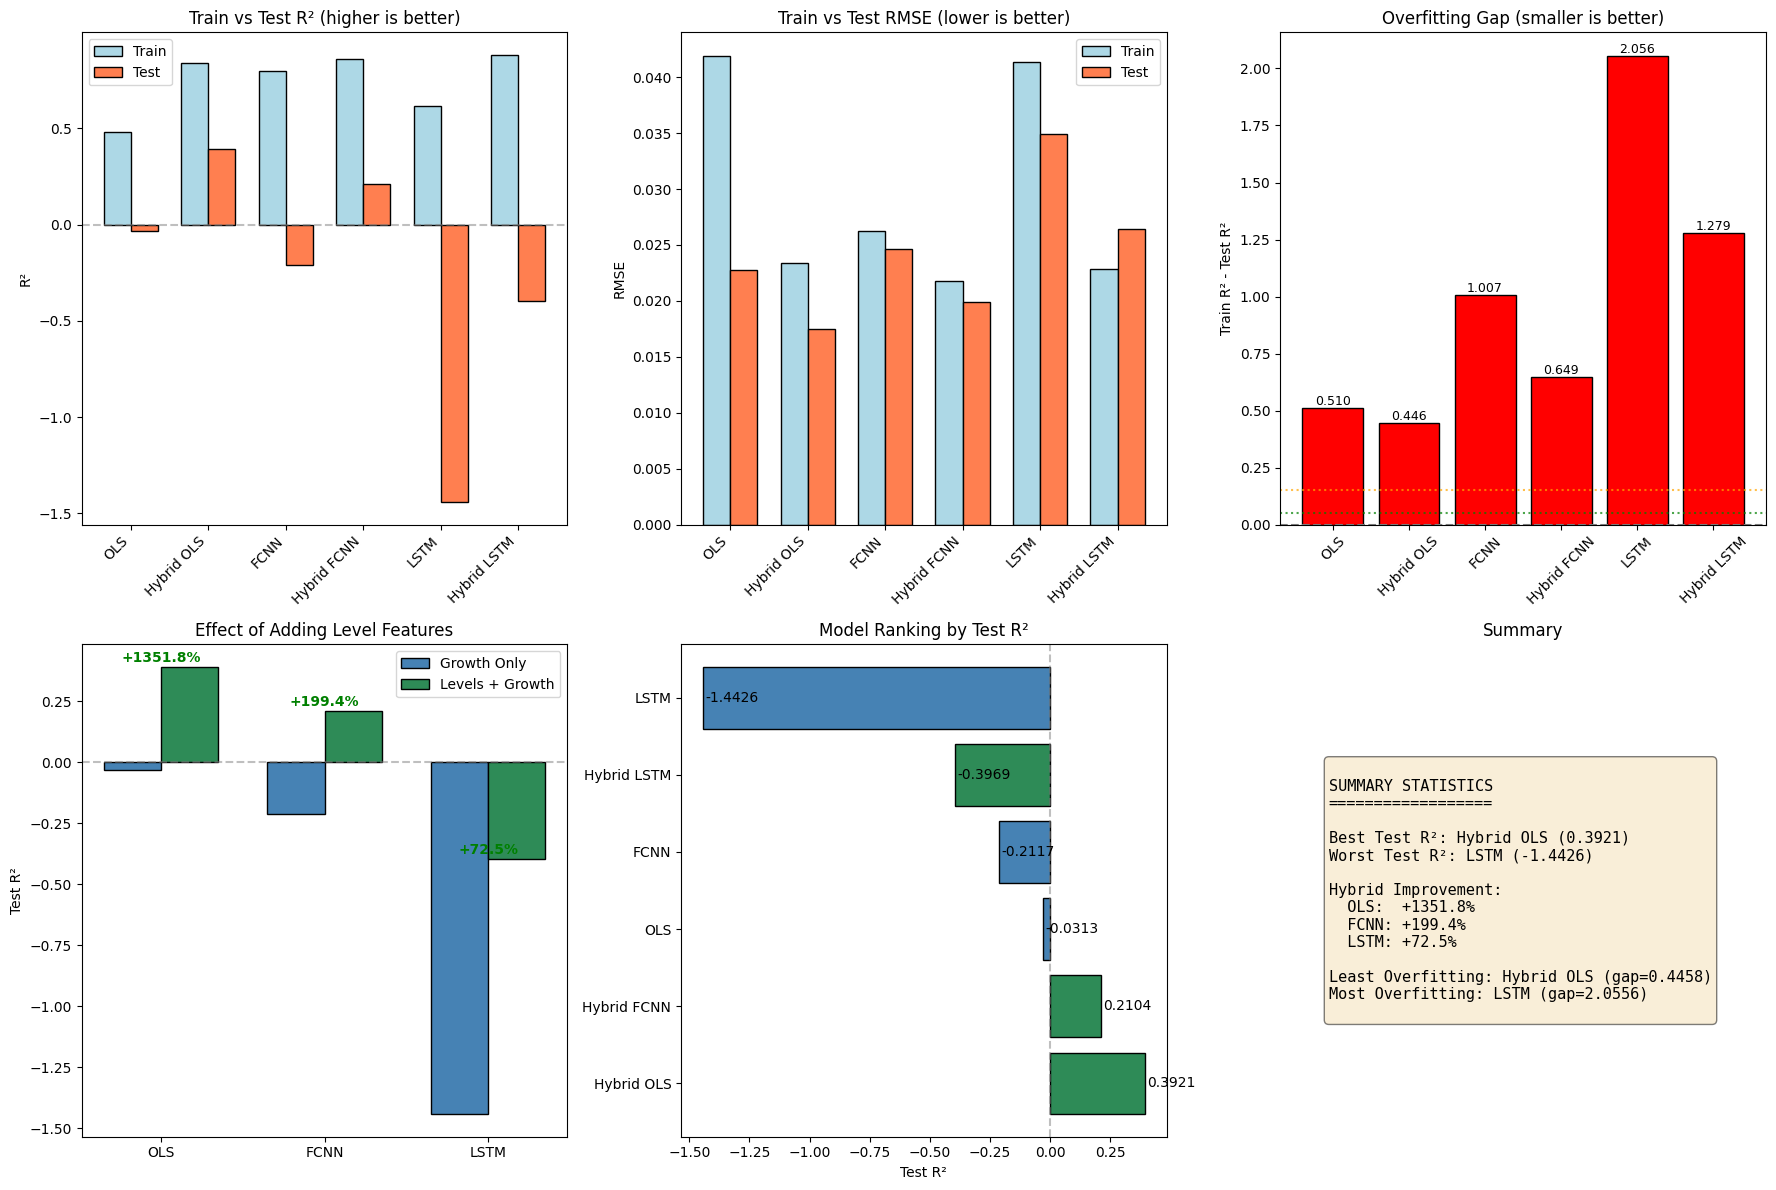

In [164]:
# Visualization: Comprehensive comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

model_names = list(all_models.keys())
train_r2_vals = [all_models[m]['train_r2'] for m in model_names]
test_r2_vals = [all_models[m]['test_r2'] for m in model_names]
train_rmse_vals = [all_models[m]['train_rmse'] for m in model_names]
test_rmse_vals = [all_models[m]['test_rmse'] for m in model_names]
gap_vals = [all_models[m]['train_r2'] - all_models[m]['test_r2'] for m in model_names]

# Color scheme: basic models in blue tones, hybrid in green tones
colors = ['steelblue', 'seagreen', 'steelblue', 'seagreen', 'steelblue', 'seagreen']

x = np.arange(len(model_names))
width = 0.35

# Plot 1: Train vs Test R²
bars1 = axes[0, 0].bar(x - width/2, train_r2_vals, width, label='Train', color='lightblue', edgecolor='black')
bars2 = axes[0, 0].bar(x + width/2, test_r2_vals, width, label='Test', color='coral', edgecolor='black')
axes[0, 0].set_ylabel('R²')
axes[0, 0].set_title('Train vs Test R² (higher is better)')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Plot 2: Train vs Test RMSE
bars1 = axes[0, 1].bar(x - width/2, train_rmse_vals, width, label='Train', color='lightblue', edgecolor='black')
bars2 = axes[0, 1].bar(x + width/2, test_rmse_vals, width, label='Test', color='coral', edgecolor='black')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('Train vs Test RMSE (lower is better)')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 1].legend()

# Plot 3: Overfitting Gap
gap_colors = ['green' if g < 0.05 else 'orange' if g < 0.15 else 'red' for g in gap_vals]
bars = axes[0, 2].bar(model_names, gap_vals, color=gap_colors, edgecolor='black')
axes[0, 2].axhline(y=0, color='gray', linestyle='--')
axes[0, 2].axhline(y=0.05, color='green', linestyle=':', alpha=0.7)
axes[0, 2].axhline(y=0.15, color='orange', linestyle=':', alpha=0.7)
axes[0, 2].set_ylabel('Train R² - Test R²')
axes[0, 2].set_title('Overfitting Gap (smaller is better)')
axes[0, 2].tick_params(axis='x', rotation=45)
for bar, val in zip(bars, gap_vals):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.3f}', 
                    ha='center', va='bottom', fontsize=9)

# Plot 4: Test R² by model type (Growth-only vs Hybrid)
growth_only = ['OLS', 'FCNN', 'LSTM']
hybrid = ['Hybrid OLS', 'Hybrid FCNN', 'Hybrid LSTM']
x_pairs = np.arange(3)
width_pair = 0.35

growth_r2 = [all_models[m]['test_r2'] for m in growth_only]
hybrid_r2 = [all_models[m]['test_r2'] for m in hybrid]

bars1 = axes[1, 0].bar(x_pairs - width_pair/2, growth_r2, width_pair, label='Growth Only', color='steelblue', edgecolor='black')
bars2 = axes[1, 0].bar(x_pairs + width_pair/2, hybrid_r2, width_pair, label='Levels + Growth', color='seagreen', edgecolor='black')
axes[1, 0].set_ylabel('Test R²')
axes[1, 0].set_title('Effect of Adding Level Features')
axes[1, 0].set_xticks(x_pairs)
axes[1, 0].set_xticklabels(['OLS', 'FCNN', 'LSTM'])
axes[1, 0].legend()
axes[1, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Add improvement labels
for i, (g, h) in enumerate(zip(growth_r2, hybrid_r2)):
    improvement = (h - g) / abs(g) * 100 if g != 0 else 0
    color = 'green' if improvement > 0 else 'red'
    axes[1, 0].annotate(f'{improvement:+.1f}%', xy=(i, max(g, h) + 0.02), 
                        ha='center', fontsize=10, color=color, fontweight='bold')

# Plot 5: Test R² ranking
sorted_models = sorted(all_models.items(), key=lambda x: x[1]['test_r2'], reverse=True)
sorted_names = [m[0] for m in sorted_models]
sorted_r2 = [m[1]['test_r2'] for m in sorted_models]
sorted_colors = ['seagreen' if 'Hybrid' in n else 'steelblue' for n in sorted_names]

bars = axes[1, 1].barh(range(len(sorted_names)), sorted_r2, color=sorted_colors, edgecolor='black')
axes[1, 1].set_yticks(range(len(sorted_names)))
axes[1, 1].set_yticklabels(sorted_names)
axes[1, 1].set_xlabel('Test R²')
axes[1, 1].set_title('Model Ranking by Test R²')
axes[1, 1].axvline(x=0, color='gray', linestyle='--', alpha=0.5)

for bar, val in zip(bars, sorted_r2):
    axes[1, 1].text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.4f}', 
                    va='center', fontsize=10)

# Plot 6: Summary statistics
summary_text = f"""
SUMMARY STATISTICS
==================

Best Test R²: {sorted_names[0]} ({sorted_r2[0]:.4f})
Worst Test R²: {sorted_names[-1]} ({sorted_r2[-1]:.4f})

Hybrid Improvement:
  OLS:  {(all_models['Hybrid OLS']['test_r2'] - all_models['OLS']['test_r2'])/abs(all_models['OLS']['test_r2'])*100:+.1f}%
  FCNN: {(all_models['Hybrid FCNN']['test_r2'] - all_models['FCNN']['test_r2'])/abs(all_models['FCNN']['test_r2'])*100:+.1f}%
  LSTM: {(all_models['Hybrid LSTM']['test_r2'] - all_models['LSTM']['test_r2'])/abs(all_models['LSTM']['test_r2'])*100:+.1f}%

Least Overfitting: {model_names[np.argmin(gap_vals)]} (gap={min(gap_vals):.4f})
Most Overfitting: {model_names[np.argmax(gap_vals)]} (gap={max(gap_vals):.4f})
"""
axes[1, 2].text(0.1, 0.5, summary_text, transform=axes[1, 2].transAxes, 
                fontsize=11, verticalalignment='center', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 2].axis('off')
axes[1, 2].set_title('Summary')

plt.tight_layout()
plt.show()

In [165]:
# Final summary and conclusions
print("=" * 90)
print("CONCLUSIONS")
print("=" * 90)

# Analyze hybrid benefit
print("\n1. DOES ADDING LEVEL FEATURES HELP?")
print("-" * 50)
for base, hybrid in [('OLS', 'Hybrid OLS'), ('FCNN', 'Hybrid FCNN'), ('LSTM', 'Hybrid LSTM')]:
    base_r2 = all_models[base]['test_r2']
    hybrid_r2 = all_models[hybrid]['test_r2']
    improvement = (hybrid_r2 - base_r2) / abs(base_r2) * 100 if base_r2 != 0 else 0
    symbol = '✓' if improvement > 0 else '✗'
    print(f"  {base:12s}: {base_r2:.4f} → {hybrid_r2:.4f} ({improvement:+.1f}%) {symbol}")

# Best model
best_model = max(all_models.items(), key=lambda x: x[1]['test_r2'])
print(f"\n2. BEST PERFORMING MODEL: {best_model[0]}")
print(f"   Test R²: {best_model[1]['test_r2']:.4f}")
print(f"   Test RMSE: {best_model[1]['test_rmse']:.4f}")

# Model complexity vs performance
print("\n3. MODEL COMPLEXITY ANALYSIS")
print("-" * 50)
print("  Linear models (OLS):")
print(f"    Best: {'Hybrid OLS' if all_models['Hybrid OLS']['test_r2'] > all_models['OLS']['test_r2'] else 'OLS'}")
print("  Neural networks (FCNN):")
print(f"    Best: {'Hybrid FCNN' if all_models['Hybrid FCNN']['test_r2'] > all_models['FCNN']['test_r2'] else 'FCNN'}")
print("  Recurrent networks (LSTM):")
print(f"    Best: {'Hybrid LSTM' if all_models['Hybrid LSTM']['test_r2'] > all_models['LSTM']['test_r2'] else 'LSTM'}")

# Overfitting analysis
print("\n4. OVERFITTING ANALYSIS")
print("-" * 50)
for name, metrics in sorted(all_models.items(), key=lambda x: x[1]['train_r2'] - x[1]['test_r2']):
    gap = metrics['train_r2'] - metrics['test_r2']
    status = 'minimal' if gap < 0.05 else 'moderate' if gap < 0.15 else 'severe'
    print(f"  {name:15s}: Train R²={metrics['train_r2']:.4f}, Test R²={metrics['test_r2']:.4f}, Gap={gap:+.4f} ({status})")

CONCLUSIONS

1. DOES ADDING LEVEL FEATURES HELP?
--------------------------------------------------
  OLS         : -0.0313 → 0.3921 (+1351.8%) ✓
  FCNN        : -0.2117 → 0.2104 (+199.4%) ✓
  LSTM        : -1.4426 → -0.3969 (+72.5%) ✓

2. BEST PERFORMING MODEL: Hybrid OLS
   Test R²: 0.3921
   Test RMSE: 0.0175

3. MODEL COMPLEXITY ANALYSIS
--------------------------------------------------
  Linear models (OLS):
    Best: Hybrid OLS
  Neural networks (FCNN):
    Best: Hybrid FCNN
  Recurrent networks (LSTM):
    Best: Hybrid LSTM

4. OVERFITTING ANALYSIS
--------------------------------------------------
  Hybrid OLS     : Train R²=0.8379, Test R²=0.3921, Gap=+0.4458 (severe)
  OLS            : Train R²=0.4787, Test R²=-0.0313, Gap=+0.5100 (severe)
  Hybrid FCNN    : Train R²=0.8594, Test R²=0.2104, Gap=+0.6490 (severe)
  FCNN           : Train R²=0.7951, Test R²=-0.2117, Gap=+1.0068 (severe)
  Hybrid LSTM    : Train R²=0.8819, Test R²=-0.3969, Gap=+1.2788 (severe)
  LSTM           :

# Appendix

In [117]:
# Within-state normality analysis
# Check if YoY growth within each state is normally distributed

from scipy import stats
import numpy as np

def test_normality(data):
    """Run Shapiro-Wilk test, return p-value or NaN if insufficient data"""
    if len(data) < 8:  # Need minimum samples for meaningful test
        return np.nan
    data = data.dropna()
    if len(data) < 8:
        return np.nan
    try:
        _, p = stats.shapiro(data)
        return p
    except:
        return np.nan

# Get unique states with sufficient cities
state_counts = merged.groupby('State').size()
states_with_enough = state_counts[state_counts >= 8].index.tolist()
print(f"States with >= 8 cities: {len(states_with_enough)}")

# Aggregate all YoY values per state for each factor
results = []

for state in states_with_enough:
    state_data = merged[merged['State'] == state]
    n_cities = len(state_data)
    
    # Flatten all YoY values for this state
    home_vals = state_data[home_yoy_cols].values.flatten()
    home_vals = home_vals[~pd.isna(home_vals)]
    
    rent_vals = state_data[rent_yoy_cols].values.flatten()
    rent_vals = rent_vals[~pd.isna(rent_vals)]
    
    pop_vals = state_data[pop_yoy_cols].values.flatten()
    pop_vals = pop_vals[~pd.isna(pop_vals)]
    
    # Run normality tests
    home_p = test_normality(pd.Series(home_vals)) if len(home_vals) >= 8 else np.nan
    rent_p = test_normality(pd.Series(rent_vals)) if len(rent_vals) >= 8 else np.nan
    pop_p = test_normality(pd.Series(pop_vals)) if len(pop_vals) >= 8 else np.nan
    
    results.append({
        'State': state,
        'N_Cities': n_cities,
        'Home_n': len(home_vals),
        'Home_p': home_p,
        'Rent_n': len(rent_vals),
        'Rent_p': rent_p,
        'Pop_n': len(pop_vals),
        'Pop_p': pop_p
    })

results_df = pd.DataFrame(results)

# Summary statistics
alpha = 0.05
print(f"\nWithin-State Normality Test Results (Shapiro-Wilk, α={alpha})")
print("=" * 70)

for factor in ['Home', 'Rent', 'Pop']:
    p_col = f'{factor}_p'
    valid = results_df[p_col].dropna()
    normal_count = (valid >= alpha).sum()
    total = len(valid)
    print(f"{factor} YoY: {normal_count}/{total} states ({100*normal_count/total:.1f}%) cannot reject normality")

# Display full results table
print("\n" + "=" * 70)
print("Detailed Results by State:")
print(results_df.to_string(index=False, float_format=lambda x: f'{x:.4f}' if not pd.isna(x) else 'NaN'))

States with >= 8 cities: 7

Within-State Normality Test Results (Shapiro-Wilk, α=0.05)
Home YoY: 1/7 states (14.3%) cannot reject normality
Rent YoY: 0/7 states (0.0%) cannot reject normality
Pop YoY: 0/7 states (0.0%) cannot reject normality

Detailed Results by State:
State  N_Cities  Home_n  Home_p  Rent_n  Rent_p  Pop_n  Pop_p
   AZ        13     117  0.0000     114  0.0000    117 0.0000
   CA        53     477  0.0000     465  0.0000    477 0.0000
   CO        11      99  0.0013      96  0.0000     99 0.0001
   FL        32     288  0.0000     285  0.0000    288 0.0000
   NC        12     108  0.0000     101  0.0000    108 0.0000
   TX        30     270  0.0000     265  0.0000    270 0.0000
   WA        13     117  0.3429     115  0.0000    117 0.0000
